<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/CapsNet_BaseLine_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import random
from tabnanny import verbose
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

In [ ]:
import gc
gc.collect()

408

In [ ]:
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Capsule Network

In [ ]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    Vector length is treated as probability which should lies between 0 and 1. This
    function brings the vector length in the range of 0 and 1
    @param vectors: vectors to be squashed, N-dim tensor
    @param axis: the axis to squash
    @return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [ ]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    @param num_capsule: number of capsules in this layer
    @param dim_capsule: dimension of the output vectors of the capsules in this layer
    @param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    @param inputs: 4D tensor, shape=[None, width, height, channels]
    @param dim_capsule: the dim of the output vector of capsule
    @param n_channels: the number of types of capsules
    @return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


**Basic Capsule Network**

In [ ]:
class CapsuleNet:
  @staticmethod
  def build(input_shape,number_of_class,routing_count,batch_size,
            n_channels = 32,dim_capsule=16,
            kernels=[9],filters=[256],strides=[1,2]):
    
   


    input = layers.Input(shape=input_shape, batch_size=batch_size)  

    # Basic core model
    for index in range(len(kernels)):
        if index == 0 :
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(input)
        else:
            conv = layers.Conv2D(filters=filters[index], 
                                kernel_size=kernels[index], 
                                strides=strides[index], 
                                padding='valid', 
                                activation='relu', 
                                name='conv'+str(index))(conv)
  
   
    conv_1 = layers.Conv2D(filters=dim_capsule*n_channels, 
                             kernel_size=kernels[-1], 
                             strides=strides[-1], 
                             padding='valid', 
                             activation='relu', 
                             name='primary_capsule_conv')(conv)

   
    
    conv_2 = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(conv_1)
    primary_capsule = layers.Lambda(squash,name = 'primary_capsule')(conv_2)
    digitcaps = CapsuleLayer(num_capsule=number_of_class, 
                             dim_capsule=dim_capsule, 
                             routings=routing_count, 
                             name='digitcaps')(primary_capsule)    
    out_caps = Length(name='capsnet')(digitcaps)
    train_model = models.Model(input,outputs=out_caps)
    return train_model

In [ ]:

def margin_loss(y_true, y_pred):
    
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))


# Plots

Individual Model Performance

In [ ]:

# Plot model performance
def plot_model_performance(history,name):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title(f"Training Loss and Accuracy:{name}")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()
  #plt.savefig(name+'results_graph.png')

Overall Performance

In [ ]:
def plot_performance(data):
  g_performance_df = pd.read_csv(SAVE_FILE)
  display(g_performance_df)
  plt.figure()
  plot = sns.barplot(y='Model', x='Accuracy', data=g_performance_df)
  plt.show()
  #data_list = []
  #for item in data:
  #  data_list.append([item,data[item][0],data[item][1],data[item][2],data[item][3],data[item][4],data[item][5],data[item][6]])
  #
  #(accuracy,precision,recall,f1,auc,sensitivity,specificity)
  #
  #df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity'])
  #display(df)
  #plt.figure()
  #plot = sns.barplot(y='Model', x='Accuracy', data=df)
  #plt.show()

In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Dataset','Param', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE, encoding='utf-8', index=False)

  g_performance_pretrained_df =  pd.DataFrame([], columns = ['Dataset','Param', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_pretrained_df.to_csv(SAVE_FILE_PRE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def save_performance_data(new_data):
  print(f"Passed:{new_data}")
  g_performance_df = pd.read_csv(SAVE_FILE)
  data_list = g_performance_df.values.tolist()
  print(f"Existing:{data_list}")
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0] and data_list[index][1]==new_data[1]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Dataset','Param', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE, encoding='utf-8', index=False)

In [ ]:
def save_performance_data_pre_trained(new_data):
  g_performance_pretrained_df = pd.read_csv(SAVE_FILE_PRE_TRAINED)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0] and data_list[index][1]==new_data[1]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_pretrained_df = pd.DataFrame(data_list, columns = ['Dataset','Param', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_pretrained_df.to_csv(SAVE_FILE_PRE_TRAINED, encoding='utf-8', index=False)

# Training CapsNet

In [ ]:
# Train Capsule Network
@tf.autograph.experimental.do_not_convert
def train(model, data, args):
    """
    Training a CapsuleNet
    @param model: the CapsuleNet model
    @param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    @param args: arguments
    return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks to save the best model   
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights.h5', monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=1)   
    
    # Early Stopping, if accurcay not imporving for 25 epoch, stop the training
    early_stopping =  callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, \
                       patience=60)                                            
    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],run_eagerly=True,
                  metrics={'capsnet': 'accuracy'})

    # Train the model
    train_image_generator = ImageDataGenerator()  
    train_data_generator = train_image_generator.flow(x_train, y_train, batch_size=args.batch_size)
    val_image_generator = ImageDataGenerator()
    val_data_generator = val_image_generator.flow(x_test,y_test,batch_size = args.batch_size)
   
    history = model.fit(train_data_generator,
                        steps_per_epoch = int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs, 
                        verbose = 1,             
                        validation_data=val_data_generator,                         
                        callbacks=[checkpoint,early_stopping])
 
    index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    best_val_accuracy = history.history["val_accuracy"][index]    
    print(f"Best Validation Accuracy:{best_val_accuracy}") 
    plot_model_performance(history,args.name)
   
    return model

In [ ]:


def get_model_train_test(data,args,n_channels = 32,
                                      dim_capsule=16,
                                      kernels=[9],
                                      filters=[256],
                                      strides=[1,2],
                                      split_for_validation = False):
  
   print(f"Received validate_test:{n_channels},{dim_capsule},{kernels},{filters},{strides},{split_for_validation}")
   
   set_seed()
   (x_train,y_train),(x_test,y_test) = data

   print(f"Received Train:{x_train.shape[0]}")  
   print(f"Received Test:{x_test.shape[0]}")
   if split_for_validation == True:
      x_train,x_validate,y_train,y_validate = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=1/9, 
                                                      random_state=100)
   else:
      x_validate,y_validate = x_test,y_test

   print(f"New Train:{x_train.shape[0]}")  
   print(f"New Validate:{x_validate.shape[0]}")
      

   # Build the model
   model = CapsuleNet.build(input_shape=x_train.shape[1:], 
                                      number_of_class=len(np.unique(np.argmax(y_train, 1))),
                                      routing_count=args.routings,
                                      batch_size=args.batch_size,
                                      n_channels=n_channels,
                                      dim_capsule = dim_capsule,
                                      kernels = kernels,
                                      filters= filters,
                                      strides = strides)

   model.summary()
   

   print(f"Train:{x_train.shape[0]}")
   print(f"Validate:{x_validate.shape[0]}")
   print(f"Test:{x_test.shape[0]}")

   trained_model = train(model=model, 
                        data=((x_train, y_train), (x_validate, y_validate)), 
                        args=args)
   #Load the weight where accuracy was maximum
   if split_for_validation == False:
      trained_model.load_weights(f'./result/weights.h5')
   # Model Training Done
   #Prediction and calculate the matrix value
 
  
   y_pred= trained_model.predict(x_test,batch_size=x_test.shape[0])
  
   accuracy = np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0]


   result_pred = np.argmax(y_pred, axis=1) 
   result_actual = np.argmax(y_test, axis=1) 
   precision = precision_score(result_actual, result_pred)
   recall = recall_score(result_actual, result_pred)
   f1 = f1_score(result_actual, result_pred)
   tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
   fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
   auc = metrics.auc(fpr, tpr)
   sensitivity = tp/(tp+fn)
   specificity = tn/(tn+fp)
   ConfusionMatrixDisplay.from_predictions(result_actual, result_pred)
   plt.show()
   kappa = cohen_kappa_score(result_actual, result_pred)
   model_performance = [(args.name,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa)]
   df = pd.DataFrame(model_performance, columns = ['Dataset', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
   display(df)
  

   return (accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa)

**Arguments**

In [ ]:


def get_arguments():
    parser = argparse.ArgumentParser(description="Capsule Network Glaucoma Classification.")
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--name', default='CapsNet', type=str)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--lr', default=0.0001, type=float,
                            help="Initial learning rate")
    parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=1, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
    parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
    parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
    parser.add_argument('--save_dir', default='./result')
    parser.add_argument('--augmentation', default=False, type=bool)
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
    parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
    args, unknown = parser.parse_known_args()
    #print(args)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    return args  

# Dataset

In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'
DRISHTI_GS1 = '/content/gdrive/My Drive/MSC_Project/Dataset/Drishti-GS1'
SAVE_FILE = r'/content/gdrive/My Drive/MSC_Project/Model/cpasnet/generated_data/CapsNet_Baseline_4.csv'
SAVE_FILE_PRE_TRAINED = r'/content/gdrive/My Drive/MSC_Project/Model/cpasnet/generated_data/CapsNet_Baseline_Pre_Trained_4.csv'
HEIGHT= 64
WIDTH = 64
BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 50
NUM_EPOCHS_B = 50

In [ ]:

# Resize image to HEIGHT*WIDTH
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height,histogram_eq = False):
    
    print(f"Width:{width},Hist:{histogram_eq}")
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                if histogram_eq == True:
                  #full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2YUV)
                  #full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  #full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_YUV2BGR)
                  full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_RGB2HSV)
                  full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_HSV2RGB)
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label


In [ ]:
def get_combined_dataset(width,height,test_train_ratio = 0.2,histogram_eq = True):
   print(f"Height:{height} Width:{width}:Hist:{histogram_eq}")
   class_labels = {}
   training_images_r1v2,training_labels_r1v2 = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)
    
   training_images_dh_gb1,training_labels_dhgb1 = process_image(DRISHTI_GS1,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)

   training_images_acrima,training_labels_acrima = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)

   training_images_r1dl,training_labels_r1dl = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)

   test_images_r1dl,test_labels_r1dl = process_image(RIM_ONE_DL_DIR+"/test_set",
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)                                                  
 
   training_labels = np.concatenate((training_labels_r1v2,training_labels_dhgb1,training_labels_acrima,training_labels_r1dl,test_labels_r1dl), axis=0)
  
   training_images = np.concatenate((training_images_r1v2,training_images_dh_gb1,training_images_acrima,training_images_r1dl,test_images_r1dl), axis=0)

   training_label = (pd.Series(training_labels).map(class_labels)).values
   training_label = to_categorical(training_label.astype('float32'))
   training_images = training_images.reshape(-1, width, width, 3).astype('float32')

   X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

   return (X_train,y_train),(X_test,y_test)


**RIMONE V2**

In [ ]:

def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = True):
  print(f"Height:{height} Width:{width} Hist:{histogram_eq}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

RIM-ONE v2 
DRISTI-GS1 

In [ ]:
# Combine the DRISHTI_GS1 and RIMONE-V2 dataset
def get_rim_one_db_r2_v2(width,height,test_train_ratio = 0.2,histogram_eq = True):
  print(f"Height:{height} Width:{width}:Hist:{histogram_eq}")
  
  class_labels = {}
  training_images_r1v2,training_labels_r1v2 = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)
    
  training_images_dh_gb1,training_labels_dhgb1 = process_image(DRISHTI_GS1,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)                                                  
 
  training_labels = np.concatenate((training_labels_r1v2,training_labels_dhgb1), axis=0)
  
  training_images = np.concatenate((training_images_r1v2,training_images_dh_gb1), axis=0)

  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

**ACRIMA**

In [ ]:
def get_acrima_dataset(width,height,test_train_ratio = 0.2,histogram_eq = True):
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width,height, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

**RIM-ONE DL**

In [ ]:
def get_rim_one_dl_dataset(width,height,histogram_eq = True):
    class_labels = {}
    training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",class_labels,width,height)
    training_label = (pd.Series(training_labels).map(class_labels)).values
    training_label = to_categorical(training_label.astype('float32'))

    test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",class_labels,width,height)
    test_label = (pd.Series(test_labels).map(class_labels)).values
    test_label = to_categorical(test_label.astype('float32'))
    
    return (training_images,training_label),(test_images,test_label)

# High Level Model

In [ ]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name,inputshape):
  set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "xception":
     model = tf.keras.applications.Xception(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "DenseNet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNetV2":
     model = tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionResNetV2":
     model = tf.keras.applications.InceptionResNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = inputshape)  
  elif trained_model_name == "NASNetMobile":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = inputshape)         
  
  if model != None:
    model.trainable = False

  return model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
def get_early_stoping_cb_on_min_val_loss(patience_num = 6):
  return EarlyStopping(monitor='val_acc', mode='max', verbose=1, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_max_val_acc(file_name):
  return ModelCheckpoint(file_name, monitor="val_acc", 	mode="max", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <100:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=0)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_max_val_acc(file_name)]

In [ ]:
class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name, inputshape = (224,224,3)):

    set_seed()
    
    #Start constructing the model with pretrained network 
    self.model = tf.keras.models.Sequential(name = trained_model_name)
    
    # Get Pretrained model with top layer removed and trainable parameter frozen
    self.high_level_model_obj = get_high_level_model(trained_model_name, \
                                                     inputshape)
    self.model.add(self.high_level_model_obj)
    
    # Flatten the output and add FC & Softmax layer
    self.model.add(tf.keras.layers.Flatten())
    #self.model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    #self.model.add(tf.keras.layers.Dense(512, activation='relu'))  
    self.model.add(tf.keras.layers.Dense(2, activation='sigmoid'))                             
    
    #Model is constructed Now
    print(self.model.summary())    
    
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    # Setting Model JSON file and weight filte name 
    self.model_wt_file_name_a = []
    self.model_wt_file_name_b = []
    self.model_file_name = self.model.name+".json"
    self.model_wt_file_name =f"{self.model.name}_wt.hdf5"
    self.fold_accuracy_a = []
    self.fold_accuracy_b = []
    
    # To identify the variantion in parameter 
    #self.model_varient = varient

  def train_phase(self,train_x,train_y,test_x,test_y,validate_x,validate_y):
    train_data_generator = ImageDataGenerator()
    train_generator = train_data_generator.flow(train_x, train_y, batch_size=32)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(validate_x, validate_y, batch_size=32)

    self.model.compile(loss='binary_crossentropy', \
          optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),metrics=['accuracy'])
    
    model_json = self.model.to_json()
    with open(self.model_file_name, "w") as json_file:
       json_file.write(model_json)

    history = self.model.fit(train_x,train_y, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=(validate_x,validate_y), \
                   callbacks = get_all_callback(self.model_wt_file_name))   
                   
    best_val_accuracy = max(history.history["val_accuracy"])
    plot_model_performance(history,self.model.name)
    self.model.load_weights(self.model_wt_file_name)
    y_pred= self.model.predict(test_x,batch_size=test_x.shape[0])
    accuracy = np.sum(np.argmax(y_pred, 1) == np.argmax(test_y, 1)) / test_y.shape[0]
    result_pred = np.argmax(y_pred, axis=1) 
    result_actual = np.argmax(test_y, axis=1) 
    precision = precision_score(result_actual, result_pred)
    recall = recall_score(result_actual, result_pred)
    f1 = f1_score(result_actual, result_pred)
    tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
    auc = metrics.auc(fpr, tpr)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    model_performance = [(self.model.name+'Tr',accuracy,precision,recall,f1,auc,sensitivity,specificity)]
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity'])
    display(df)


    self.model.load_weights(self.model_wt_file_name)
    self.high_level_model_obj.trainable = True

    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
    self.model.compile(loss='binary_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name))

    best_val_accuracy = max(history.history["val_accuracy"])
    self.fold_accuracy_b.append(best_val_accuracy)      
    plot_model_performance(history,self.model.name)
    gc.collect()

    
    
    self.model.load_weights(self.model_wt_file_name)
    
    y_pred= self.model.predict(test_x,batch_size=test_x.shape[0])
    accuracy = np.sum(np.argmax(y_pred, 1) == np.argmax(test_y, 1)) / test_y.shape[0]
    result_pred = np.argmax(y_pred, axis=1) 
    result_actual = np.argmax(test_y, axis=1) 
    precision = precision_score(result_actual, result_pred)
    recall = recall_score(result_actual, result_pred)
    f1 = f1_score(result_actual, result_pred)
    tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
    fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
    auc = metrics.auc(fpr, tpr)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    kappa = cohen_kappa_score(result_actual, result_pred)
    model_performance = [(self.model.name+'FineTuning',accuracy,precision,recall,f1,auc,sensitivity,specificity)]
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity'])
    display(df)
    
    #save_performance_data_pre_trained([self.model.name+'_fineTuning',final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity])
   

In [ ]:
@tf.autograph.experimental.do_not_convert
def get_model_train_test_pre_trained(data,model_name):
  
   
   set_seed()
   (x_train,y_train),(x_test,y_test) = data

   print(f"Received Train:{x_train.shape[0]}")  
   print(f"Received Test:{x_test.shape[0]}")
   x_train,x_validate,y_train,y_validate = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=1/9, 
                                                      random_state=100)
   print(f"New Train:{x_train.shape[0]}")  
   print(f"New Validate:{x_validate.shape[0]}")
   model = HIGH_LEVEL_MODEL(model_name,inputshape=(x_train.shape[1],x_train.shape[1],3))

   
   model.train_phase(x_train,y_train,x_test,y_test,x_validate,y_validate)

Height:64 Width:64
Received Train:444
Received Test:112
New Train:394
New Validate:50
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 14,718,786
Trainable params: 4,098
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/50
 9/13 [===================>..........] - ETA: 0s - loss: 0.7280 - accuracy: 0.5035
Epoch 1: val_accuracy improved from -inf to 0.32000, saving model to vgg16_wt.hdf5
13/13 [==============================] - 

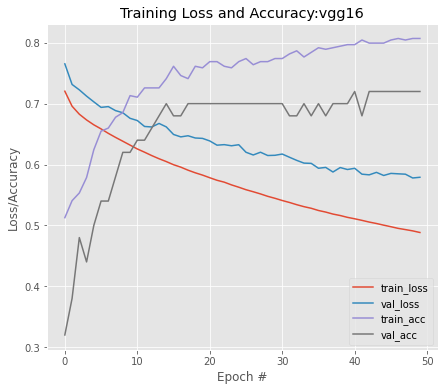

Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg16Tr  0.839286   0.790323  0.907407  0.844828  0.841635     0.907407   

   Specificity  
0     0.775862

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7614
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to vgg16_wt.hdf5
13/13 [==============================] - 3s 82ms/step - loss: 0.5529 - accuracy: 0.7614 - val_loss: 0.4813 - val_accuracy: 0.7000
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.7995
Epoch 2: val_accuracy improved from 0.70000 to 0.74000, saving model to vgg16_wt.hdf5
13/13 [==============================] - 1s 64ms/step - loss: 0.4196 - accuracy: 0.7995 - val_loss: 0.5600 - val_accuracy: 0.7400
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8503
Epoch 3: val_accuracy did not improve from 0.74000
13/13 [==============================] - 0s 37ms/step - loss: 0.3276 - accuracy: 0.8503 - val_loss: 0.5979 - val_accuracy: 0.7400
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8782
Epoch 4: val_a

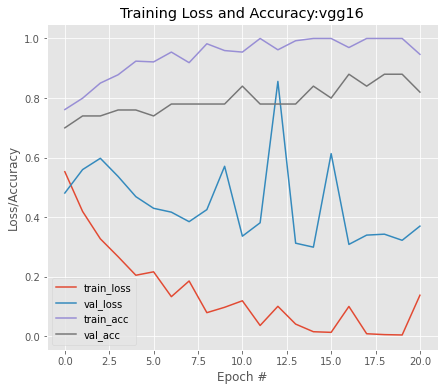

Model  Accuracy  Precision    Recall        F1       AUC  \
0  vgg16FineTuning  0.928571   0.942308  0.907407  0.924528  0.927842   

   Sensitivity  Specificity  
0     0.907407     0.948276

In [ ]:
get_model_train_test_pre_trained(get_rim_one_db_r2_v2(width=64,height=64,histogram_eq=True),'vgg16')

Height:64 Width:64
Received Train:444
Received Test:112
New Train:394
New Validate:50
58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 14,718,786
Trainable params: 4,098
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5152
Epoch 1: val_accuracy improved from -inf to 0.28000, saving

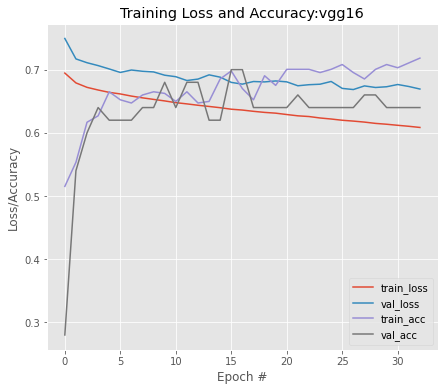

Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg16Tr  0.696429   0.727273  0.592593  0.653061  0.692848     0.592593   

   Specificity  
0     0.793103

Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 0.6220 - accuracy: 0.6878
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to vgg16_wt.hdf5
13/13 [==============================] - 4s 94ms/step - loss: 0.6153 - accuracy: 0.6954 - val_loss: 0.5893 - val_accuracy: 0.7000
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.7766
Epoch 2: val_accuracy did not improve from 0.70000
13/13 [==============================] - 0s 36ms/step - loss: 0.4923 - accuracy: 0.7766 - val_loss: 0.5675 - val_accuracy: 0.7000
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8198
Epoch 3: val_accuracy did not improve from 0.70000
13/13 [==============================] - 0s 37ms/step - loss: 0.4082 - accuracy: 0.8198 - val_loss: 0.7183 - val_accuracy: 0.6800
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8553
Epoch 4: val_accuracy did not improve from 0.7000

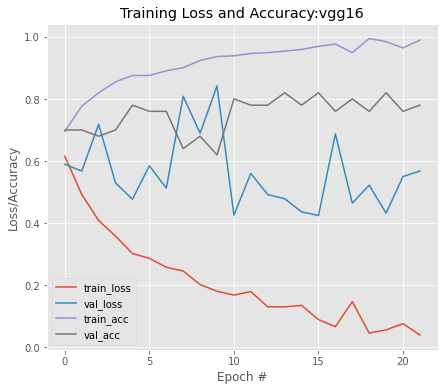

Model  Accuracy  Precision    Recall    F1       AUC  \
0  vgg16FineTuning  0.892857   0.956522  0.814815  0.88  0.890166   

   Sensitivity  Specificity  
0     0.814815     0.965517

In [ ]:
get_model_train_test_pre_trained(get_rim_one_db_r2_v2(width=64,height=64,histogram_eq=False),'vgg16')


Basic CapsNet

In [ ]:
def get_dataset(data_set_name,width,height,histogram_eq = True, train_test_split=0.2):
  if data_set_name =='RIM-ONE_V2_DRISTI_GS1':
    return get_rim_one_db_r2_v2(width=width,height=height,histogram_eq=histogram_eq)
  if data_set_name =='RIMONE_V2':
    return get_rim_one_db_r2(width=width,height=height,histogram_eq=histogram_eq,test_train_ratio=train_test_split)
  if data_set_name =='RIMONE_DL':
    return get_rim_one_dl_dataset(width=width,height=height,histogram_eq=histogram_eq)
  if data_set_name =='ACRIMA':
    return get_acrima_dataset(width=width,height=height,histogram_eq=histogram_eq,test_train_ratio=train_test_split)
  if data_set_name == 'COMBINED':
    return get_combined_dataset(width=width,height=height,histogram_eq=histogram_eq,test_train_ratio=train_test_split)

In [ ]:
def run_basic_capsnet(dataset_name,width,height,rounting_count,
                      histogram_eq=True,
                      epoch = 200, 
                      filter = [256], 
                      kernel = [9], 
                      stride = [1,2], 
                      validation_split = True):
    gc.collect()
    print(f'Model:Dataset:{dataset_name}, Image size:{width}*{height}, Routing Count:{rounting_count},HisT:{histogram_eq},filter:{filter},kernel:{kernel},stride:{stride},validation_split:{validation_split}')
    args = get_arguments()
    args.batch_size = 32
    args.epochs = epoch
    args.routings = rounting_count
    args.name = f'{dataset_name}'#_IMG_{width}_R_{rounting_count}_H_{histogram_eq}_{filter}_{kernel}_{stride}_V_{validation_split}'
    param = f'IMG_{width}_R_{rounting_count}_H_{histogram_eq}_F_{filter}_K_{kernel}_S_{stride}_V_{validation_split}'
    data_set = get_dataset(dataset_name,width,height,histogram_eq=histogram_eq)  
    
    (accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = get_model_train_test(data = data_set,args = args,kernels=kernel,filters=filter,strides=stride,split_for_validation = validation_split)
    return (args.name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa)

In [ ]:
def run_task1(dataset_name,width,height,
                      epoch = 200, 
                      filter = [256], 
                      kernel = [9], 
                      stride = [1,2], 
                      validation_split = True):
    gc.collect()
    ROUTING_COUNT = [1,8]
    HISTOGRAM_EQ=[True,False]
    print(f'Model:Dataset:{dataset_name}, Image size:{width}*{height},filter:{filter},kernel:{kernel},stride:{stride},validation_split:{validation_split}')
    args = get_arguments()
    args.batch_size = 32
    args.epochs = epoch
    
    args.name = f'{dataset_name}'
    for hist in HISTOGRAM_EQ:
       data_set = get_dataset(dataset_name,width,height,histogram_eq=hist)
       for rout_count in  ROUTING_COUNT:
          args.routings = rout_count
          param = f'IMG_{width}_R_{rout_count}_H_{hist}_F_{filter}_K_{kernel}_S_{stride}_V_{validation_split}'
          (accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = get_model_train_test(data = data_set,args = args,kernels=kernel,filters=filter,strides=stride,split_for_validation = validation_split)
          save_performance_data([args.name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa])

In [ ]:
def run_task4(dataset_name,width,height,
                      epoch = 200, 
                      filter = [256], 
                      kernel = [9], 
                      stride = [1,2], 
                      validation_split = True):
    gc.collect()
    ROUTING_COUNT = [8]
    HISTOGRAM_EQ=[True]
    print(f'Model:Dataset:{dataset_name}, Image size:{width}*{height},filter:{filter},kernel:{kernel},stride:{stride},validation_split:{validation_split}')
    args = get_arguments()
    args.batch_size = 32
    args.epochs = epoch
    SPLIT_RATIO = [0.1,0.2,0.3,0.4,0.5,0.6]
    
    
    for ratio in SPLIT_RATIO:
       args.name = f'{dataset_name}_R_{ratio}'
       data_set = get_dataset(dataset_name,width,height,histogram_eq=True,train_test_split=ratio)
       args.routings = 8
       param = f'IMG_{width}_R_{8}_H_True_F_{filter}_K_{kernel}_S_{stride}_V_{validation_split}'
       (accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = get_model_train_test(data = data_set,args = args,kernels=kernel,filters=filter,strides=stride,split_for_validation = validation_split)
       save_performance_data([args.name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa])

In [ ]:

  

def call_baseline_model(data_set_name,validation_split = True):
  model_performances = {}
  IMG_SIZE = [64]
  ROUNTING = [8,1]
  HISTOGRAM =[True]
  FILTERS = [[256],[128],[64]]
  KERNELS = [[9],[7],[7]]
  STRIDE = [[1,2],[1,2],[1,2]]

  for image_size in IMG_SIZE:
    for routing_count in ROUNTING:
      for item in HISTOGRAM:
        for index in range(len(FILTERS)):
          set_seed()          
          (name,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = run_basic_capsnet(dataset_name = data_set_name,width = image_size,height = image_size,rounting_count = routing_count,histogram_eq=item,filter = FILTERS[index],kernel = KERNELS[index],stride=STRIDE[index],validation_split=validation_split )
          model_performances[name] = [accuracy,precision,recall,f1,auc,sensitivity,specificity]
          save_performance_data([name,accuracy,precision,recall,f1,auc,sensitivity,specificity])

  plot_performance(model_performances)  

In [ ]:
def task1_baseline(dataset_name = 'RIM-ONE_V2_DRISTI_GS1', validation_split = True, image_size = 64):
   set_seed() 
   HISTOGRAM = [False,True]
   ROUTING_COUNT = [8,1]
   for routing in ROUTING_COUNT:
      for hist in HISTOGRAM:
         (name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = run_basic_capsnet(dataset_name = dataset_name,width = image_size,height = image_size,rounting_count = routing,histogram_eq=hist,validation_split=validation_split )
         save_performance_data([name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa])


In [ ]:
def task3_baseline(dataset_name = 'RIM-ONE_V2_DRISTI_GS1', validation_split = True, image_size = 64, routing_count = 1):
   set_seed()  
   FILTERS = [[256],[128],[64],[64],[128],[256],[256]]
   KERNELS = [[9],[7],[7],[5],[9],[5],[9]]
   STRIDE = [[1,2],[1,2],[1,2],[1,2],[1,2],[1,2],[1]]
   ROUTING_COUNT = routing_count
   data_set = get_dataset(dataset_name,image_size,image_size,histogram_eq=True)
   args = get_arguments()
   args.batch_size = 32
   args.epochs = 200
   args.routings = ROUTING_COUNT
   for index in range(0,len(FILTERS)):
      args.name = f'{dataset_name}_F_EXP'
      param = f'IMG_{image_size}_R_{ROUTING_COUNT}_H_True_F_{FILTERS[index]}_K_{KERNELS[index]}_S_{STRIDE[index]}_V_{validation_split}'
      (accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa) = get_model_train_test(data = data_set,args = args,kernels=KERNELS[index],filters=FILTERS[index],strides=STRIDE[index],split_for_validation = validation_split)
      save_performance_data([args.name,param,accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa])  
      


In [ ]:
def plot_task1(dataset = 'RIM-ONE_V2_DRISTI_GS1'):
   g_performance_df = pd.read_csv(SAVE_FILE)
   data_list = g_performance_df.values.tolist()
   df1 = g_performance_df[g_performance_df['Dataset']==dataset]
   print(df1)
   print(df1.to_latex())

In [ ]:
def plot_task4(dataset = 'RIM-ONE_V2_DRISTI_GS1'):
   g_performance_df = pd.read_csv(SAVE_FILE)
   data_list = g_performance_df.values.tolist()
   df1 = g_performance_df[g_performance_df['Dataset'].str.contains(f"{dataset}_R_0.")]
   print(df1)
   print(df1.to_latex())

In [ ]:
initialise_df_perfromance_matrix()

Starting Test on 15/04/2022

14/04/2022

In [ ]:
plot_task1('RIM-ONE_V2_DRISTI_GS1')

                 Dataset                                             Param  \
0  RIM-ONE_V2_DRISTI_GS1   IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True   
1  RIM-ONE_V2_DRISTI_GS1   IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True   
2  RIM-ONE_V2_DRISTI_GS1  IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True   
3  RIM-ONE_V2_DRISTI_GS1  IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_True   

   Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  0.901786   0.977778  0.814815  0.888889  0.898787     0.814815   
1  0.892857   0.977273  0.796296  0.877551  0.889527     0.796296   
2  0.892857   0.903846  0.870370  0.886792  0.892082     0.870370   
3  0.875000   0.916667  0.814815  0.862745  0.872925     0.814815   

   Specificity     kappa  
0     0.982759  0.802184  
1     0.982759  0.784062  
2     0.913793  0.785166  
3     0.931034  0.748718  
\begin{tabular}{lllrrrrrrrr}
\toprule
{} &                Dataset &                                             Param &  Accurac

In [ ]:
plot_task1('RIMONE_V2')

     Dataset                                              Param  Accuracy  \
4  RIMONE_V2   IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False  0.901099   
5  RIMONE_V2   IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False  0.901099   
6  RIMONE_V2  IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_False  0.857143   
7  RIMONE_V2  IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_False  0.868132   

   Precision    Recall        F1       AUC  Sensitivity  Specificity     kappa  
4   0.900000  0.878049  0.888889  0.899024     0.878049         0.92  0.799804  
5   0.880952  0.902439  0.891566  0.901220     0.902439         0.90  0.800681  
6   0.833333  0.853659  0.843373  0.856829     0.853659         0.86  0.712095  
7   0.853659  0.853659  0.853659  0.866829     0.853659         0.88  0.733659  
\begin{tabular}{lllrrrrrrrr}
\toprule
{} &    Dataset &                                              Param &  Accuracy &  Precision &    Recall &        F1 &       AUC &  Sensitivity &  Specificity &     kappa

Model:Dataset:RIM-ONE_V2_DRISTI_GS1, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:True
Height:64 Width:64:Hist:True
Width:64,Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],True
Received Train:444
Received Test:112
New Train:394
New Validate:50
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.5138
Epoch 1: val_loss improved from inf to 0.37848, saving model to ./result/weights.h5
12/12 [==============================] - 5s 433ms/step - loss: 0.4521 - accuracy: 0.5138 - val_loss: 0.3785 - val_accuracy: 0.2800
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.5525
Epoch 2: val_loss improved from 0.37848 to 0.35827, saving model to ./result/weights.h5
12/12 [==============================] - 3s 292ms/step - loss: 0.2839 - accuracy: 0.5525 - val_loss: 0.3583 - val_accuracy: 0.2800
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.35827 to 0.32975, saving model to ./result/weights.h5
12/12 [==============================] - 3s 291ms/step - loss: 0.2858 - accuracy: 0.5000 - val_loss: 0.3298 - val_accuracy: 0.2800
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.248

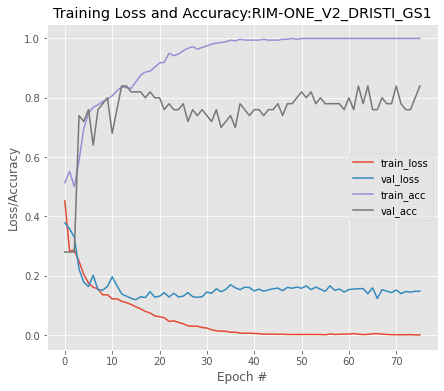

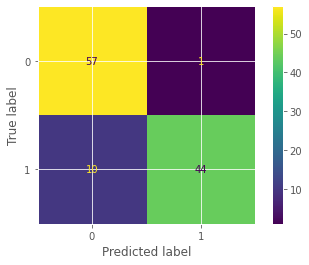

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIM-ONE_V2_DRISTI_GS1  0.901786   0.977778  0.814815  0.888889  0.898787   

   Sensitivity  Specificity     Kappa  
0     0.814815     0.982759  0.802184

Passed:['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857143, 0.9777777777777777, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896551, 0.8021836865767502]
Existing:[]
Received validate_test:32,16,[9],[256],[1, 2],True
Received Train:444
Received Test:112
New Train:394
New Validate:50
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_resh

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.5138
Epoch 1: val_loss improved from inf to 0.37855, saving model to ./result/weights.h5
12/12 [==============================] - 4s 366ms/step - loss: 0.4522 - accuracy: 0.5138 - val_loss: 0.3786 - val_accuracy: 0.2800
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.5442
Epoch 2: val_loss improved from 0.37855 to 0.35798, saving model to ./result/weights.h5
12/12 [==============================] - 4s 361ms/step - loss: 0.2845 - accuracy: 0.5442 - val_loss: 0.3580 - val_accuracy: 0.2800
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.35798 to 0.33268, saving model to ./result/weights.h5
12/12 [==============================] - 4s 358ms/step - loss: 0.2863 - accuracy: 0.5000 - val_loss: 0.3327 - val_accuracy: 0.2800
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.250

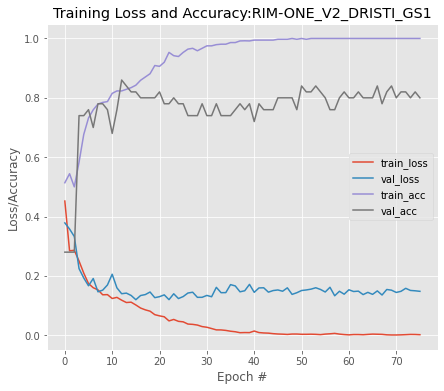

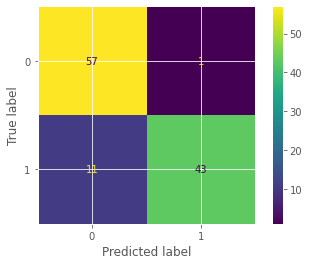

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIM-ONE_V2_DRISTI_GS1  0.892857   0.977273  0.796296  0.877551  0.889527   

   Sensitivity  Specificity     Kappa  
0     0.796296     0.982759  0.784062

Passed:['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727273, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896551, 0.7840616966580977]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502]]
Height:64 Width:64:Hist:False
Width:64,Hist:False
Width:64,Hist:False
Received validate_test:32,16,[9],[256],[1, 2],True
Received Train:444
Received Test:112
New Train:394
New Validate:50
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.5166
Epoch 1: val_loss improved from inf to 0.38447, saving model to ./result/weights.h5
12/12 [==============================] - 4s 308ms/step - loss: 0.4525 - accuracy: 0.5166 - val_loss: 0.3845 - val_accuracy: 0.2800
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.4890
Epoch 2: val_loss improved from 0.38447 to 0.30876, saving model to ./result/weights.h5
12/12 [==============================] - 4s 309ms/step - loss: 0.3452 - accuracy: 0.4890 - val_loss: 0.3088 - val_accuracy: 0.7200
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.30876 to 0.27878, saving model to ./result/weights.h5
12/12 [==============================] - 4s 308ms/step - loss: 0.3291 - accuracy: 0.5000 - val_loss: 0.2788 - val_accuracy: 0.7200
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.258

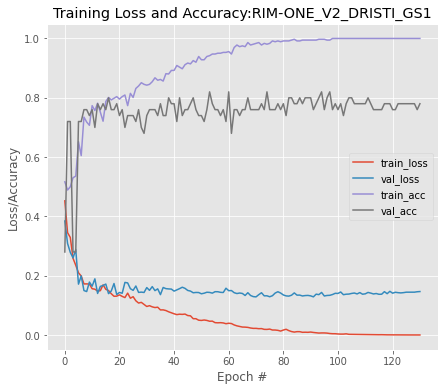

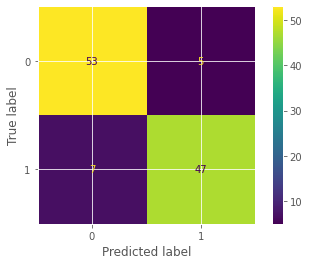

Dataset  Accuracy  Precision   Recall        F1       AUC  \
0  RIM-ONE_V2_DRISTI_GS1  0.892857   0.903846  0.87037  0.886792  0.892082   

   Sensitivity  Specificity     Kappa  
0      0.87037     0.913793  0.785166

Passed:['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9038461538461539, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.9137931034482759, 0.7851662404092071]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977]]
Received validate_test:32,16,[9],[256],[1, 2],True
Received Train:444
Received Test:112
New Train:394
New Validate:50
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.5166
Epoch 1: val_loss improved from inf to 0.38456, saving model to ./result/weights.h5
12/12 [==============================] - 4s 361ms/step - loss: 0.4525 - accuracy: 0.5166 - val_loss: 0.3846 - val_accuracy: 0.2800
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.4890
Epoch 2: val_loss improved from 0.38456 to 0.33223, saving model to ./result/weights.h5
12/12 [==============================] - 4s 356ms/step - loss: 0.3457 - accuracy: 0.4890 - val_loss: 0.3322 - val_accuracy: 0.7200
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.33223 to 0.24370, saving model to ./result/weights.h5
12/12 [==============================] - 4s 356ms/step - loss: 0.3315 - accuracy: 0.5000 - val_loss: 0.2437 - val_accuracy: 0.7200
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.260

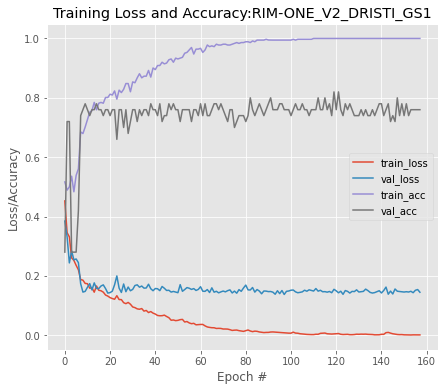

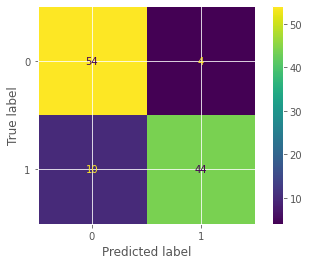

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIM-ONE_V2_DRISTI_GS1     0.875   0.916667  0.814815  0.862745  0.872925   

   Sensitivity  Specificity     Kappa  
0     0.814815     0.931034  0.748718

Passed:['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.875, 0.9166666666666666, 0.8148148148148148, 0.8627450980392156, 0.8729246487867177, 0.8148148148148148, 0.9310344827586207, 0.7487179487179487]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071]]


In [ ]:
run_task1(dataset_name='RIM-ONE_V2_DRISTI_GS1',width=64,height=64,validation_split=True)

Model:Dataset:RIMONE_V2, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:False
Height:64 Width:64 Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:364
Received Test:91
New Train:364
New Validate:91
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.29985, saving model to ./result/weights.h5
11/11 [==============================] - 19s 482ms/step - loss: 0.4419 - accuracy: 0.4789 - val_loss: 0.2999 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.5512
Epoch 2: val_loss improved from 0.29985 to 0.23515, saving model to ./result/weights.h5
11/11 [==============================] - 4s 326ms/step - loss: 0.2512 - accuracy: 0.5512 - val_loss: 0.2351 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.5843
Epoch 3: val_loss improved from 0.23515 to 0.22514, saving model to ./result/weights.h5
11/11 [==============================] - 4s 327ms/step - loss: 0.2217 - accuracy: 0.5843 - val_loss: 0.2251 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.20

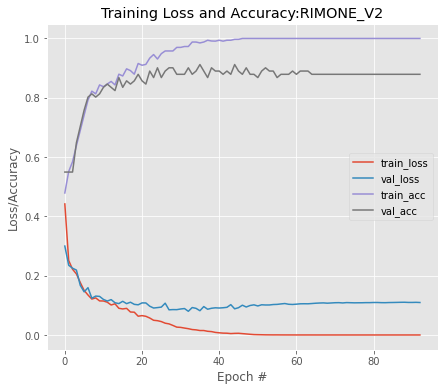

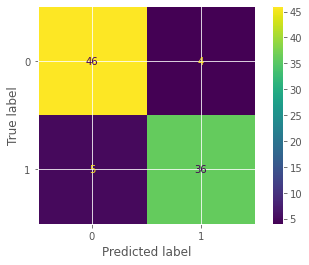

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_V2  0.901099        0.9  0.878049  0.888889  0.899024     0.878049   

   Specificity     Kappa  
0         0.92  0.799804

Passed:['RIMONE_V2', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9010989010989011, 0.9, 0.8780487804878049, 0.888888888888889, 0.8990243902439025, 0.8780487804878049, 0.92, 0.7998044487900269]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_True'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.29978, saving model to ./result/weights.h5
11/11 [==============================] - 4s 397ms/step - loss: 0.4420 - accuracy: 0.4789 - val_loss: 0.2998 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.29978 to 0.23520, saving model to ./result/weights.h5
11/11 [==============================] - 4s 409ms/step - loss: 0.2513 - accuracy: 0.5482 - val_loss: 0.2352 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.5843
Epoch 3: val_loss improved from 0.23520 to 0.22530, saving model to ./result/weights.h5
11/11 [==============================] - 4s 411ms/step - loss: 0.2217 - accuracy: 0.5843 - val_loss: 0.2253 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.207

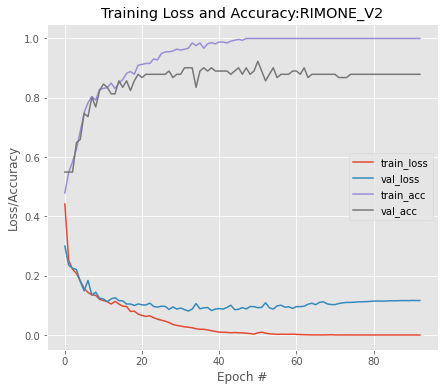

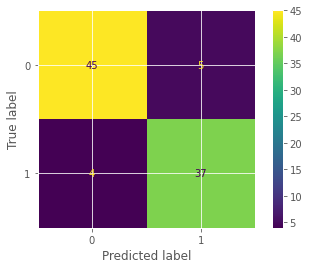

Dataset  Accuracy  Precision    Recall        F1      AUC  Sensitivity  \
0  RIMONE_V2  0.901099   0.880952  0.902439  0.891566  0.90122     0.902439   

   Specificity     Kappa  
0          0.9  0.800681

Passed:['RIMONE_V2', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9010989010989011, 0.8809523809523809, 0.9024390243902439, 0.8915662650602411, 0.901219512195122, 0.9024390243902439, 0.9, 0.8006814310051107]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.5151
Epoch 1: val_loss improved from inf to 0.28455, saving model to ./result/weights.h5
11/11 [==============================] - 4s 324ms/step - loss: 0.4341 - accuracy: 0.5151 - val_loss: 0.2846 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.5452
Epoch 2: val_loss improved from 0.28455 to 0.22961, saving model to ./result/weights.h5
11/11 [==============================] - 3s 317ms/step - loss: 0.2439 - accuracy: 0.5452 - val_loss: 0.2296 - val_accuracy: 0.6264
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.5873
Epoch 3: val_loss did not improve from 0.22961
11/11 [==============================] - 3s 300ms/step - loss: 0.2199 - accuracy: 0.5873 - val_loss: 0.2328 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.6205
Epoch 4: val_loss im

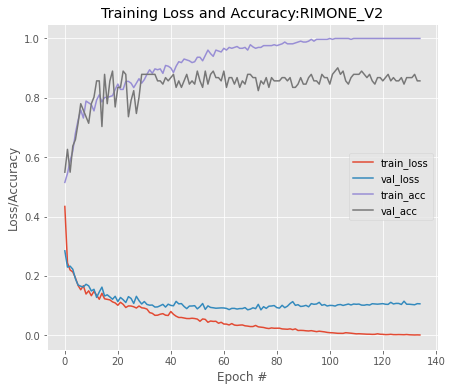

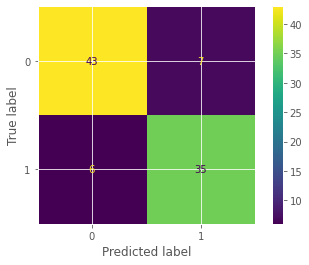

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_V2  0.857143   0.833333  0.853659  0.843373  0.856829     0.853659   

   Specificity     Kappa  
0         0.86  0.712095

Passed:['RIMONE_V2', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8571428571428571, 0.8333333333333334, 0.8536585365853658, 0.8433734939759037, 0.8568292682926829, 0.8536585365853658, 0.86, 0.7120954003407155]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.5151
Epoch 1: val_loss improved from inf to 0.28474, saving model to ./result/weights.h5
11/11 [==============================] - 4s 376ms/step - loss: 0.4341 - accuracy: 0.5151 - val_loss: 0.2847 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.5452
Epoch 2: val_loss improved from 0.28474 to 0.22959, saving model to ./result/weights.h5
11/11 [==============================] - 4s 368ms/step - loss: 0.2441 - accuracy: 0.5452 - val_loss: 0.2296 - val_accuracy: 0.5934
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.5813
Epoch 3: val_loss did not improve from 0.22959
11/11 [==============================] - 4s 351ms/step - loss: 0.2199 - accuracy: 0.5813 - val_loss: 0.2326 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.6175
Epoch 4: val_loss im

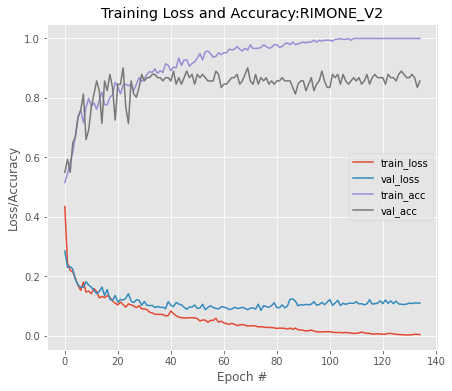

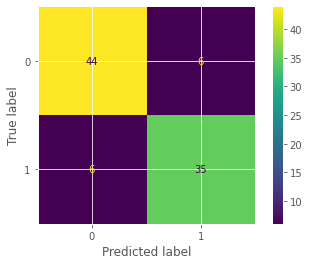

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_V2  0.868132   0.853659  0.853659  0.853659  0.866829     0.853659   

   Specificity     Kappa  
0         0.88  0.733659

Passed:['RIMONE_V2', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8681318681318682, 0.8536585365853658, 0.8536585365853658, 0.8536585365853658, 0.8668292682926829, 0.8536585365853658, 0.88, 0.7336585365853658]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]

In [ ]:
run_task1(dataset_name='RIMONE_V2',width=64,height=64,validation_split=False)

RIM-ONE R2

Model:Dataset:RIMONE_V2, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:False
Height:64 Width:64 Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:409
Received Test:46
New Train:409
New Validate:46
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.5146
Epoch 1: val_loss improved from inf to 0.29994, saving model to ./result/weights.h5
12/12 [==============================] - 12s 533ms/step - loss: 0.4378 - accuracy: 0.5146 - val_loss: 0.2999 - val_accuracy: 0.5217
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.5650
Epoch 2: val_loss improved from 0.29994 to 0.23423, saving model to ./result/weights.h5
12/12 [==============================] - 6s 487ms/step - loss: 0.2708 - accuracy: 0.5650 - val_loss: 0.2342 - val_accuracy: 0.6522
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.5756
Epoch 3: val_loss improved from 0.23423 to 0.22119, saving model to ./result/weights.h5
12/12 [==============================] - 6s 490ms/step - loss: 0.2254 - accuracy: 0.5756 - val_loss: 0.2212 - val_accuracy: 0.5217
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.20

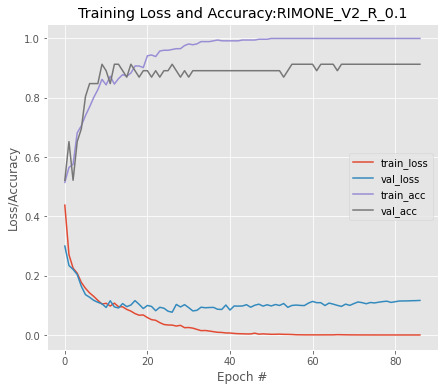

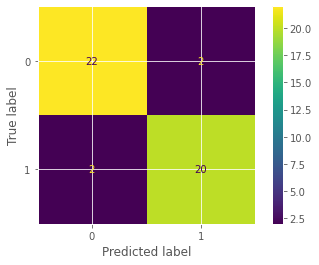

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_R_0.1  0.913043   0.909091  0.909091  0.909091  0.912879   

   Sensitivity  Specificity     Kappa  
0     0.909091     0.916667  0.825758

Passed:['RIMONE_V2_R_0.1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9130434782608695, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9128787878787878, 0.9090909090909091, 0.9166666666666666, 0.8257575757575757]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.29974, saving model to ./result/weights.h5
11/11 [==============================] - 6s 592ms/step - loss: 0.4420 - accuracy: 0.4789 - val_loss: 0.2997 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.29974 to 0.23517, saving model to ./result/weights.h5
11/11 [==============================] - 4s 374ms/step - loss: 0.2513 - accuracy: 0.5482 - val_loss: 0.2352 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.5843
Epoch 3: val_loss improved from 0.23517 to 0.22535, saving model to ./result/weights.h5
11/11 [==============================] - 4s 373ms/step - loss: 0.2217 - accuracy: 0.5843 - val_loss: 0.2254 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.207

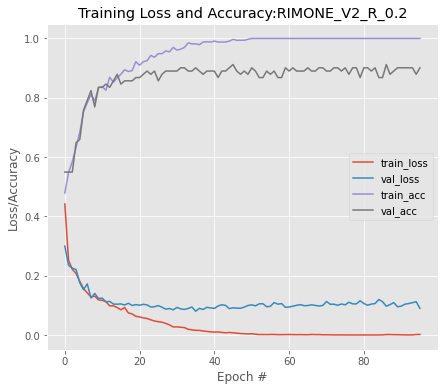

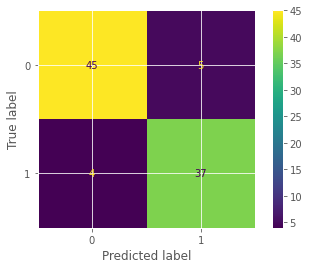

Dataset  Accuracy  Precision    Recall        F1      AUC  \
0  RIMONE_V2_R_0.2  0.901099   0.880952  0.902439  0.891566  0.90122   

   Sensitivity  Specificity     Kappa  
0     0.902439          0.9  0.800681

Passed:['RIMONE_V2_R_0.2', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9010989010989011, 0.8809523809523809, 0.9024390243902439, 0.8915662650602411, 0.901219512195122, 0.9024390243902439, 0.9, 0.8006814310051107]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.4860
Epoch 1: val_loss improved from inf to 0.38282, saving model to ./result/weights.h5
9/9 [==============================] - 8s 902ms/step - loss: 0.4776 - accuracy: 0.4860 - val_loss: 0.3828 - val_accuracy: 0.5766
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.5664
Epoch 2: val_loss improved from 0.38282 to 0.23468, saving model to ./result/weights.h5
9/9 [==============================] - 4s 422ms/step - loss: 0.3393 - accuracy: 0.5664 - val_loss: 0.2347 - val_accuracy: 0.5766
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.4825
Epoch 3: val_loss did not improve from 0.23468
9/9 [==============================] - 4s 402ms/step - loss: 0.2588 - accuracy: 0.4825 - val_loss: 0.2372 - val_accuracy: 0.5766
Epoch 4/200
9/9 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.5315
Epoch 4: val_loss improved from 0.

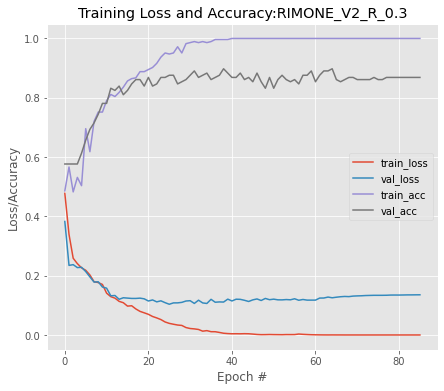

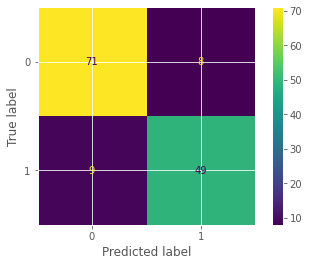

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_R_0.3  0.875912   0.859649  0.844828  0.852174  0.871781   

   Sensitivity  Specificity    Kappa  
0     0.844828     0.898734  0.74527

Passed:['RIMONE_V2_R_0.3', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8759124087591241, 0.8596491228070176, 0.8448275862068966, 0.8521739130434783, 0.8717808817110433, 0.8448275862068966, 0.8987341772151899, 0.7452696051624192]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.4108
Epoch 1: val_loss improved from inf to 0.38771, saving model to ./result/weights.h5
8/8 [==============================] - 6s 801ms/step - loss: 0.5017 - accuracy: 0.4108 - val_loss: 0.3877 - val_accuracy: 0.4341
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.4375
Epoch 2: val_loss improved from 0.38771 to 0.37964, saving model to ./result/weights.h5
8/8 [==============================] - 4s 451ms/step - loss: 0.3894 - accuracy: 0.4375 - val_loss: 0.3796 - val_accuracy: 0.4341
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.5519
Epoch 3: val_loss improved from 0.37964 to 0.27957, saving model to ./result/weights.h5
8/8 [==============================] - 3s 431ms/step - loss: 0.3179 - accuracy: 0.5519 - val_loss: 0.2796 - val_accuracy: 0.5659
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 

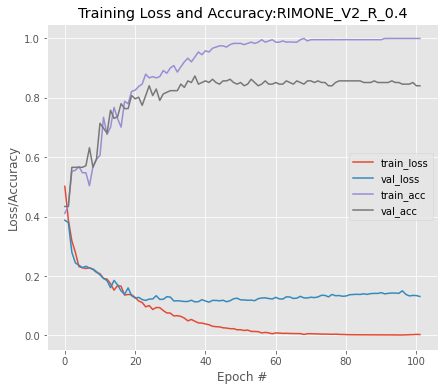

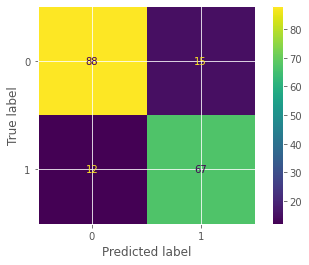

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_R_0.4  0.851648   0.817073  0.848101  0.832298  0.851235   

   Sensitivity  Specificity     Kappa  
0     0.848101     0.854369  0.699376

Passed:['RIMONE_V2_R_0.4', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8516483516483516, 0.8170731707317073, 0.8481012658227848, 0.8322981366459627, 0.85123509893081, 0.8481012658227848, 0.8543689320388349, 0.6993759941270036]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_Fa

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.5333
Epoch 1: val_loss improved from inf to 0.37760, saving model to ./result/weights.h5
7/7 [==============================] - 4s 561ms/step - loss: 0.4952 - accuracy: 0.5333 - val_loss: 0.3776 - val_accuracy: 0.5702
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.5179
Epoch 2: val_loss improved from 0.37760 to 0.31888, saving model to ./result/weights.h5
7/7 [==============================] - 3s 452ms/step - loss: 0.3318 - accuracy: 0.5179 - val_loss: 0.3189 - val_accuracy: 0.4298
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.4667
Epoch 3: val_loss did not improve from 0.31888
7/7 [==============================] - 3s 422ms/step - loss: 0.3430 - accuracy: 0.4667 - val_loss: 0.3766 - val_accuracy: 0.4298
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.4154
Epoch 4: val_loss did not improve 

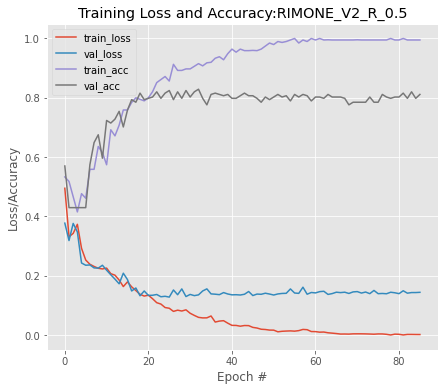

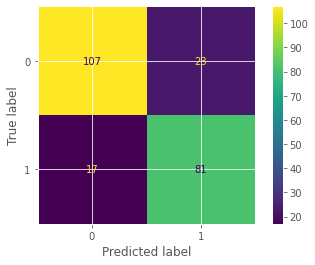

Dataset  Accuracy  Precision    Recall       F1       AUC  \
0  RIMONE_V2_R_0.5  0.824561   0.778846  0.826531  0.80198  0.824804   

   Sensitivity  Specificity     Kappa  
0     0.826531     0.823077  0.644749

Passed:['RIMONE_V2_R_0.5', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8245614035087719, 0.7788461538461539, 0.826530612244898, 0.801980198019802, 0.8248037676609105, 0.826530612244898, 0.823076923076923, 0.6447491430352135]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_Fals

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.4600
Epoch 1: val_loss improved from inf to 0.36047, saving model to ./result/weights.h5
5/5 [==============================] - 4s 904ms/step - loss: 0.5402 - accuracy: 0.4600 - val_loss: 0.3605 - val_accuracy: 0.5604
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 0.3715 - accuracy: 0.5562
Epoch 2: val_loss did not improve from 0.36047
5/5 [==============================] - 3s 555ms/step - loss: 0.3715 - accuracy: 0.5562 - val_loss: 0.3606 - val_accuracy: 0.5604
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.5400
Epoch 3: val_loss improved from 0.36047 to 0.27202, saving model to ./result/weights.h5
5/5 [==============================] - 3s 576ms/step - loss: 0.3278 - accuracy: 0.5400 - val_loss: 0.2720 - val_accuracy: 0.5604
Epoch 4/200
5/5 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.4467
Epoch 4: val_loss improved from 0.

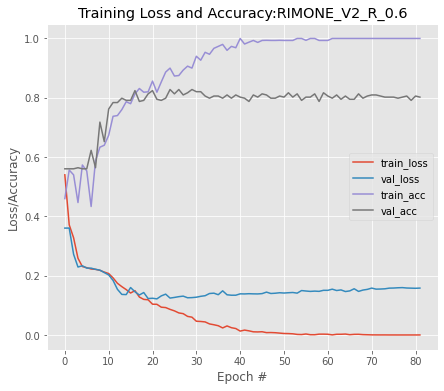

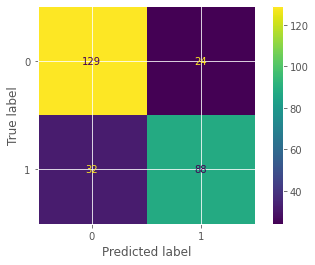

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_R_0.6  0.794872   0.785714  0.733333  0.758621  0.788235   

   Sensitivity  Specificity     Kappa  
0     0.733333     0.843137  0.580645

Passed:['RIMONE_V2_R_0.6', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.7948717948717948, 0.7857142857142857, 0.7333333333333333, 0.7586206896551724, 0.7882352941176471, 0.7333333333333333, 0.8431372549019608, 0.5806451612903226]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_

In [ ]:
run_task4('RIMONE_V2',width=64,height=64,validation_split=False)

In [ ]:
plot_task4(dataset = 'RIMONE_V2')

            Dataset                                             Param  \
8   RIMONE_V2_R_0.1  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   
9   RIMONE_V2_R_0.2  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   
10  RIMONE_V2_R_0.3  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   
11  RIMONE_V2_R_0.4  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   
12  RIMONE_V2_R_0.5  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   
13  RIMONE_V2_R_0.6  IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False   

    Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
8   0.913043   0.909091  0.909091  0.909091  0.912879     0.909091   
9   0.901099   0.880952  0.902439  0.891566  0.901220     0.902439   
10  0.875912   0.859649  0.844828  0.852174  0.871781     0.844828   
11  0.851648   0.817073  0.848101  0.832298  0.851235     0.848101   
12  0.824561   0.778846  0.826531  0.801980  0.824804     0.826531   
13  0.794872   0.785714  0.733333  0.758621  0.788235     0.733333  

Height:64 Width:64 Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:364
Received Test:91
New Train:364
New Validate:91
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                               
                                                                 
 primary_capsule (Lambda)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.29974, saving model to ./result/weights.h5
11/11 [==============================] - 4s 367ms/step - loss: 0.4420 - accuracy: 0.4789 - val_loss: 0.2997 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.29974 to 0.23517, saving model to ./result/weights.h5
11/11 [==============================] - 4s 392ms/step - loss: 0.2513 - accuracy: 0.5482 - val_loss: 0.2352 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.5843
Epoch 3: val_loss improved from 0.23517 to 0.22536, saving model to ./result/weights.h5
11/11 [==============================] - 4s 363ms/step - loss: 0.2217 - accuracy: 0.5843 - val_loss: 0.2254 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.207

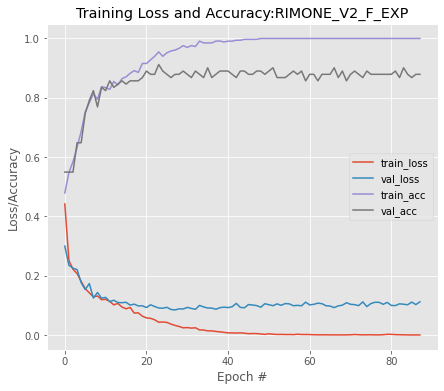

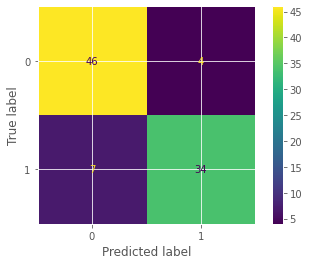

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.879121   0.894737  0.829268  0.860759  0.874634   

   Sensitivity  Specificity     Kappa  
0     0.829268         0.92  0.754235

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8791208791208791, 0.8947368421052632, 0.8292682926829268, 0.860759493670886, 0.8746341463414634, 0.8292682926829268, 0.92, 0.7542352074637859]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.33530, saving model to ./result/weights.h5
11/11 [==============================] - 5s 373ms/step - loss: 0.4485 - accuracy: 0.5361 - val_loss: 0.3353 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.33530 to 0.24803, saving model to ./result/weights.h5
11/11 [==============================] - 3s 265ms/step - loss: 0.2850 - accuracy: 0.5482 - val_loss: 0.2480 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.5542
Epoch 3: val_loss improved from 0.24803 to 0.23008, saving model to ./result/weights.h5
11/11 [==============================] - 3s 262ms/step - loss: 0.2270 - accuracy: 0.5542 - val_loss: 0.2301 - val_accuracy: 0.6374
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.220

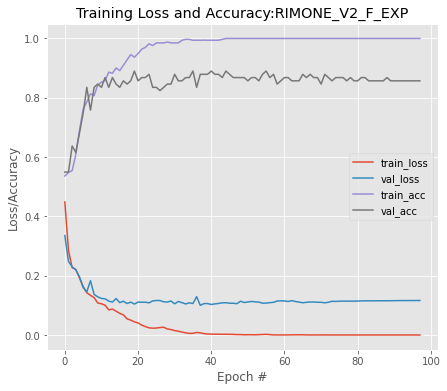

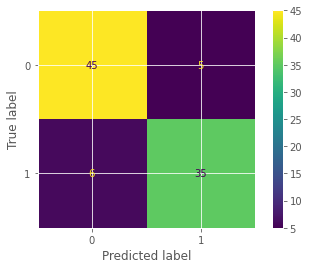

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.879121      0.875  0.853659  0.864198  0.876829   

   Sensitivity  Specificity     Kappa  
0     0.853659          0.9  0.755317

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[128]_K_[7]_S_[1, 2]_V_False', 0.8791208791208791, 0.875, 0.8536585365853658, 0.8641975308641976, 0.8768292682926829, 0.8536585365853658, 0.9, 0.7553165485211439]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.30608, saving model to ./result/weights.h5
11/11 [==============================] - 4s 267ms/step - loss: 0.4232 - accuracy: 0.5361 - val_loss: 0.3061 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.30608 to 0.23346, saving model to ./result/weights.h5
11/11 [==============================] - 2s 210ms/step - loss: 0.2556 - accuracy: 0.5482 - val_loss: 0.2335 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.5783
Epoch 3: val_loss improved from 0.23346 to 0.23162, saving model to ./result/weights.h5
11/11 [==============================] - 2s 217ms/step - loss: 0.2243 - accuracy: 0.5783 - val_loss: 0.2316 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.215

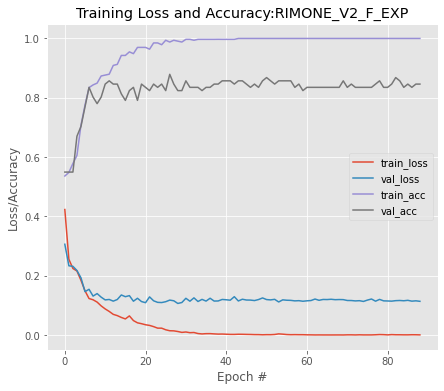

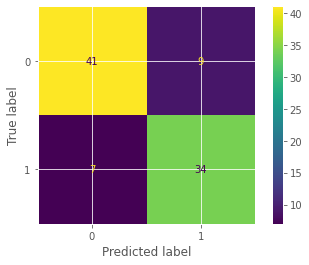

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.824176   0.790698  0.829268  0.809524  0.824634   

   Sensitivity  Specificity    Kappa  
0     0.829268         0.82  0.64643

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[64]_K_[7]_S_[1, 2]_V_False', 0.8241758241758241, 0.7906976744186046, 0.8292682926829268, 0.8095238095238095, 0.8246341463414634, 0.8292682926829268, 0.82, 0.6464303059737737]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.5572
Epoch 1: val_loss improved from inf to 0.32555, saving model to ./result/weights.h5
11/11 [==============================] - 3s 262ms/step - loss: 0.4259 - accuracy: 0.5572 - val_loss: 0.3256 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.32555 to 0.26924, saving model to ./result/weights.h5
11/11 [==============================] - 2s 225ms/step - loss: 0.2754 - accuracy: 0.5482 - val_loss: 0.2692 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.5873
Epoch 3: val_loss improved from 0.26924 to 0.23295, saving model to ./result/weights.h5
11/11 [==============================] - 2s 224ms/step - loss: 0.2287 - accuracy: 0.5873 - val_loss: 0.2329 - val_accuracy: 0.5275
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.218

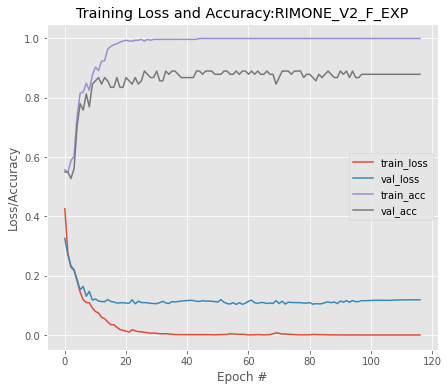

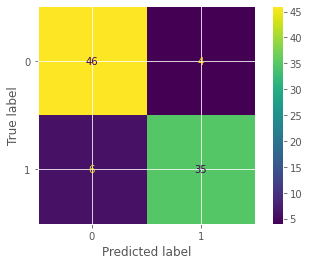

Dataset  Accuracy  Precision    Recall     F1       AUC  \
0  RIMONE_V2_F_EXP   0.89011   0.897436  0.853659  0.875  0.886829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.92  0.77707

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[64]_K_[5]_S_[1, 2]_V_False', 0.8901098901098901, 0.8974358974358975, 0.8536585365853658, 0.875, 0.8868292682926829, 0.8536585365853658, 0.92, 0.7770700636942676]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.28762, saving model to ./result/weights.h5
11/11 [==============================] - 6s 370ms/step - loss: 0.4287 - accuracy: 0.5361 - val_loss: 0.2876 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.5663
Epoch 2: val_loss improved from 0.28762 to 0.23341, saving model to ./result/weights.h5
11/11 [==============================] - 3s 249ms/step - loss: 0.2454 - accuracy: 0.5663 - val_loss: 0.2334 - val_accuracy: 0.6374
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.5964
Epoch 3: val_loss improved from 0.23341 to 0.23330, saving model to ./result/weights.h5
11/11 [==============================] - 3s 248ms/step - loss: 0.2246 - accuracy: 0.5964 - val_loss: 0.2333 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.211

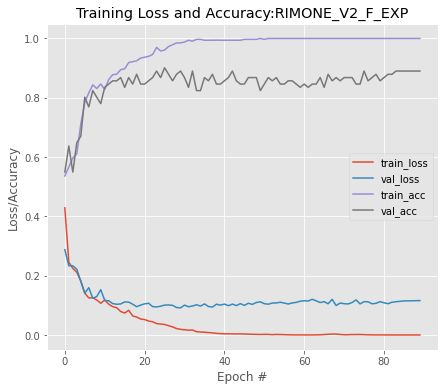

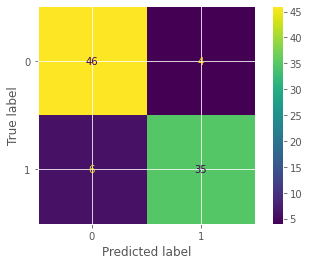

Dataset  Accuracy  Precision    Recall     F1       AUC  \
0  RIMONE_V2_F_EXP   0.89011   0.897436  0.853659  0.875  0.886829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.92  0.77707

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[128]_K_[9]_S_[1, 2]_V_False', 0.8901098901098901, 0.8974358974358975, 0.8536585365853658, 0.875, 0.8868292682926829, 0.8536585365853658, 0.92, 0.7770700636942676]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.5422
Epoch 1: val_loss improved from inf to 0.35030, saving model to ./result/weights.h5
11/11 [==============================] - 6s 439ms/step - loss: 0.4537 - accuracy: 0.5422 - val_loss: 0.3503 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.35030 to 0.24392, saving model to ./result/weights.h5
11/11 [==============================] - 4s 340ms/step - loss: 0.2919 - accuracy: 0.5482 - val_loss: 0.2439 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.5301
Epoch 3: val_loss improved from 0.24392 to 0.23899, saving model to ./result/weights.h5
11/11 [==============================] - 4s 337ms/step - loss: 0.2302 - accuracy: 0.5301 - val_loss: 0.2390 - val_accuracy: 0.6264
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.228

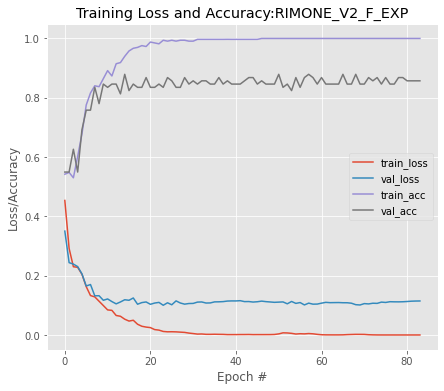

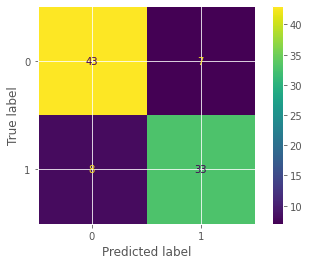

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.835165      0.825  0.804878  0.814815  0.832439   

   Sensitivity  Specificity     Kappa  
0     0.804878         0.86  0.666341

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[256]_K_[5]_S_[1, 2]_V_False', 0.8351648351648352, 0.825, 0.8048780487804879, 0.8148148148148149, 0.832439024390244, 0.8048780487804879, 0.86, 0.6663407479833782]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.5783
Epoch 1: val_loss improved from inf to 0.23027, saving model to ./result/weights.h5
11/11 [==============================] - 24s 2s/step - loss: 0.3409 - accuracy: 0.5783 - val_loss: 0.2303 - val_accuracy: 0.4505
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.7108
Epoch 2: val_loss improved from 0.23027 to 0.17341, saving model to ./result/weights.h5
11/11 [==============================] - 11s 997ms/step - loss: 0.1951 - accuracy: 0.7108 - val_loss: 0.1734 - val_accuracy: 0.7363
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.7470
Epoch 3: val_loss improved from 0.17341 to 0.13496, saving model to ./result/weights.h5
11/11 [==============================] - 11s 976ms/step - loss: 0.1434 - accuracy: 0.7470 - val_loss: 0.1350 - val_accuracy: 0.8242
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.120

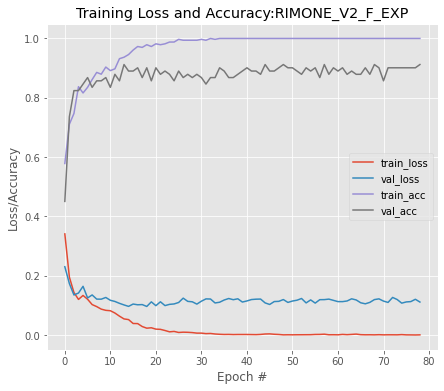

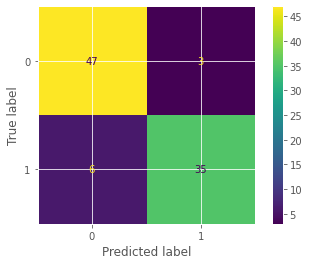

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.901099   0.921053  0.853659  0.886076  0.896829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.94  0.79892

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1]_V_False', 0.9010989010989011, 0.9210526315789473, 0.8536585365853658, 0.8860759493670887, 0.8968292682926828, 0.8536585365853658, 0.94, 0.798919715197643]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9

In [ ]:
task3_baseline('RIMONE_V2', validation_split=False)

Height:64 Width:64 Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:364
Received Test:91
New Train:364
New Validate:91
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                               
                                                                 
 primary_capsule (Lambda

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 0.29985, saving model to ./result/weights.h5
11/11 [==============================] - 4s 324ms/step - loss: 0.4419 - accuracy: 0.4789 - val_loss: 0.2998 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.5512
Epoch 2: val_loss improved from 0.29985 to 0.23515, saving model to ./result/weights.h5
11/11 [==============================] - 3s 319ms/step - loss: 0.2512 - accuracy: 0.5512 - val_loss: 0.2351 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.5843
Epoch 3: val_loss improved from 0.23515 to 0.22514, saving model to ./result/weights.h5
11/11 [==============================] - 4s 333ms/step - loss: 0.2217 - accuracy: 0.5843 - val_loss: 0.2251 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.206

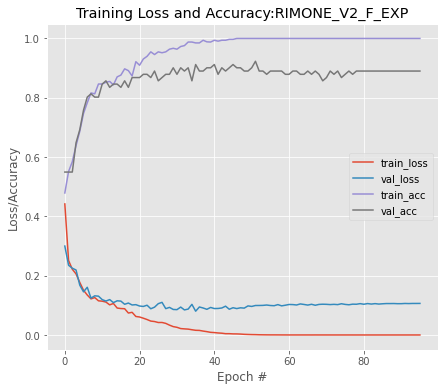

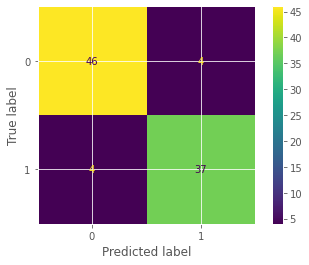

Dataset  Accuracy  Precision    Recall        F1      AUC  \
0  RIMONE_V2_F_EXP  0.912088   0.902439  0.902439  0.902439  0.91122   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.92  0.822439

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9120879120879121, 0.9024390243902439, 0.9024390243902439, 0.9024390243902439, 0.911219512195122, 0.9024390243902439, 0.92, 0.822439024390244]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.33558, saving model to ./result/weights.h5
11/11 [==============================] - 2s 212ms/step - loss: 0.4486 - accuracy: 0.5361 - val_loss: 0.3356 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.33558 to 0.24780, saving model to ./result/weights.h5
11/11 [==============================] - 2s 209ms/step - loss: 0.2848 - accuracy: 0.5482 - val_loss: 0.2478 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.5542
Epoch 3: val_loss improved from 0.24780 to 0.22988, saving model to ./result/weights.h5
11/11 [==============================] - 2s 209ms/step - loss: 0.2268 - accuracy: 0.5542 - val_loss: 0.2299 - val_accuracy: 0.6264
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.220

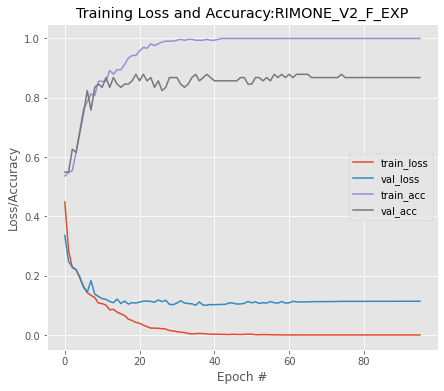

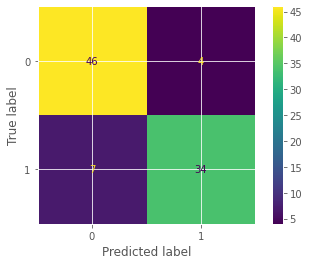

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.879121   0.894737  0.829268  0.860759  0.874634   

   Sensitivity  Specificity     Kappa  
0     0.829268         0.92  0.754235

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[128]_K_[7]_S_[1, 2]_V_False', 0.8791208791208791, 0.8947368421052632, 0.8292682926829268, 0.860759493670886, 0.8746341463414634, 0.8292682926829268, 0.92, 0.7542352074637859]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.30618, saving model to ./result/weights.h5
11/11 [==============================] - 2s 159ms/step - loss: 0.4232 - accuracy: 0.5361 - val_loss: 0.3062 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.30618 to 0.23344, saving model to ./result/weights.h5
11/11 [==============================] - 2s 157ms/step - loss: 0.2555 - accuracy: 0.5482 - val_loss: 0.2334 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.5753
Epoch 3: val_loss improved from 0.23344 to 0.23154, saving model to ./result/weights.h5
11/11 [==============================] - 2s 153ms/step - loss: 0.2243 - accuracy: 0.5753 - val_loss: 0.2315 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.216

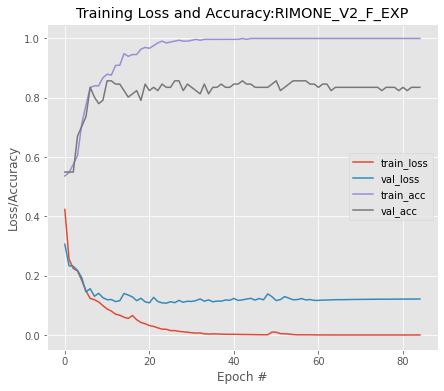

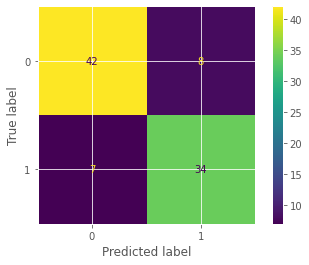

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.835165   0.809524  0.829268  0.819277  0.834634   

   Sensitivity  Specificity     Kappa  
0     0.829268         0.84  0.667802

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[64]_K_[7]_S_[1, 2]_V_False', 0.8351648351648352, 0.8095238095238095, 0.8292682926829268, 0.8192771084337348, 0.8346341463414633, 0.8292682926829268, 0.84, 0.667802385008518]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.5572
Epoch 1: val_loss improved from inf to 0.32559, saving model to ./result/weights.h5
11/11 [==============================] - 2s 162ms/step - loss: 0.4259 - accuracy: 0.5572 - val_loss: 0.3256 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.32559 to 0.26934, saving model to ./result/weights.h5
11/11 [==============================] - 2s 160ms/step - loss: 0.2754 - accuracy: 0.5482 - val_loss: 0.2693 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.5934
Epoch 3: val_loss improved from 0.26934 to 0.23293, saving model to ./result/weights.h5
11/11 [==============================] - 2s 159ms/step - loss: 0.2287 - accuracy: 0.5934 - val_loss: 0.2329 - val_accuracy: 0.5385
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.218

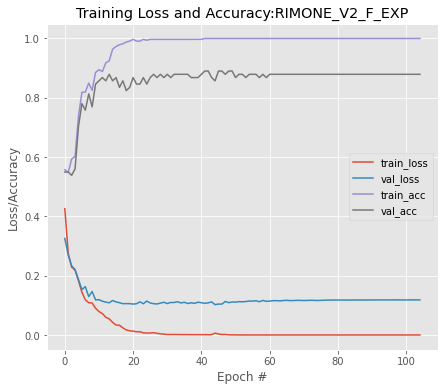

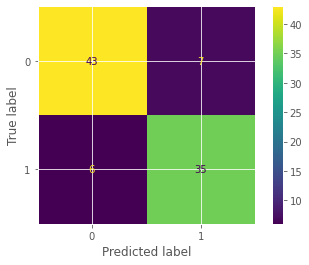

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.857143   0.833333  0.853659  0.843373  0.856829   

   Sensitivity  Specificity     Kappa  
0     0.853659         0.86  0.712095

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[64]_K_[5]_S_[1, 2]_V_False', 0.8571428571428571, 0.8333333333333334, 0.8536585365853658, 0.8433734939759037, 0.8568292682926829, 0.8536585365853658, 0.86, 0.7120954003407155]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.28765, saving model to ./result/weights.h5
11/11 [==============================] - 2s 212ms/step - loss: 0.4287 - accuracy: 0.5361 - val_loss: 0.2877 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.5663
Epoch 2: val_loss improved from 0.28765 to 0.23340, saving model to ./result/weights.h5
11/11 [==============================] - 2s 214ms/step - loss: 0.2453 - accuracy: 0.5663 - val_loss: 0.2334 - val_accuracy: 0.6484
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.5813
Epoch 3: val_loss improved from 0.23340 to 0.23294, saving model to ./result/weights.h5
11/11 [==============================] - 2s 223ms/step - loss: 0.2245 - accuracy: 0.5813 - val_loss: 0.2329 - val_accuracy: 0.5495
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.210

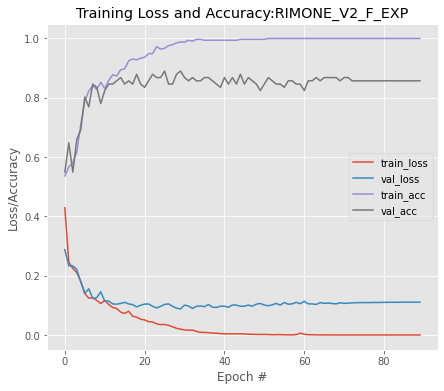

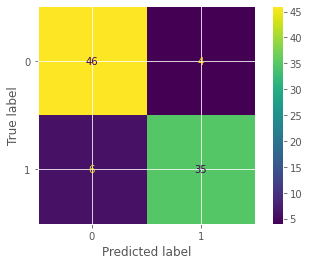

Dataset  Accuracy  Precision    Recall     F1       AUC  \
0  RIMONE_V2_F_EXP   0.89011   0.897436  0.853659  0.875  0.886829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.92  0.77707

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[128]_K_[9]_S_[1, 2]_V_False', 0.8901098901098901, 0.8974358974358975, 0.8536585365853658, 0.875, 0.8868292682926829, 0.8536585365853658, 0.92, 0.7770700636942676]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.5422
Epoch 1: val_loss improved from inf to 0.35039, saving model to ./result/weights.h5
11/11 [==============================] - 3s 285ms/step - loss: 0.4537 - accuracy: 0.5422 - val_loss: 0.3504 - val_accuracy: 0.5495
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.5482
Epoch 2: val_loss improved from 0.35039 to 0.24385, saving model to ./result/weights.h5
11/11 [==============================] - 3s 284ms/step - loss: 0.2920 - accuracy: 0.5482 - val_loss: 0.2439 - val_accuracy: 0.5495
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.5331
Epoch 3: val_loss improved from 0.24385 to 0.23888, saving model to ./result/weights.h5
11/11 [==============================] - 3s 273ms/step - loss: 0.2301 - accuracy: 0.5331 - val_loss: 0.2389 - val_accuracy: 0.6264
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.228

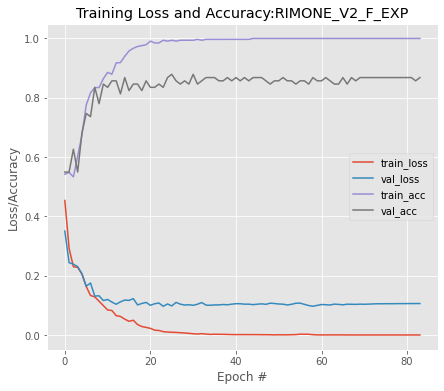

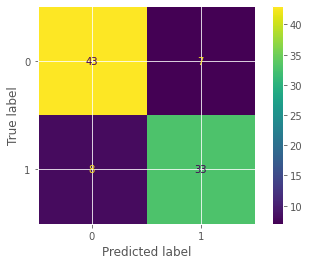

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.835165      0.825  0.804878  0.814815  0.832439   

   Sensitivity  Specificity     Kappa  
0     0.804878         0.86  0.666341

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[256]_K_[5]_S_[1, 2]_V_False', 0.8351648351648352, 0.825, 0.8048780487804879, 0.8148148148148149, 0.832439024390244, 0.8048780487804879, 0.86, 0.6663407479833782]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.5783
Epoch 1: val_loss improved from inf to 0.23029, saving model to ./result/weights.h5
11/11 [==============================] - 9s 831ms/step - loss: 0.3409 - accuracy: 0.5783 - val_loss: 0.2303 - val_accuracy: 0.4505
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.7108
Epoch 2: val_loss improved from 0.23029 to 0.17285, saving model to ./result/weights.h5
11/11 [==============================] - 9s 806ms/step - loss: 0.1951 - accuracy: 0.7108 - val_loss: 0.1729 - val_accuracy: 0.7473
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.7470
Epoch 3: val_loss improved from 0.17285 to 0.13434, saving model to ./result/weights.h5
11/11 [==============================] - 9s 803ms/step - loss: 0.1428 - accuracy: 0.7470 - val_loss: 0.1343 - val_accuracy: 0.8352
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 0.119

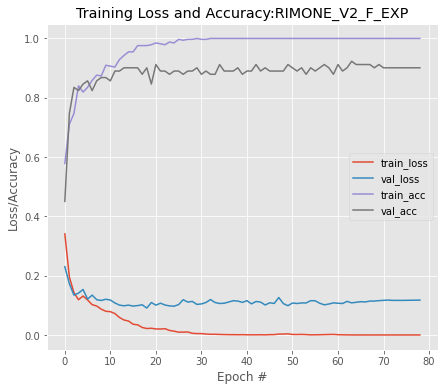

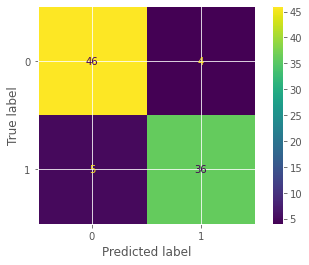

Dataset  Accuracy  Precision    Recall        F1       AUC  \
0  RIMONE_V2_F_EXP  0.901099        0.9  0.878049  0.888889  0.899024   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.92  0.799804

Passed:['RIMONE_V2_F_EXP', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1]_V_False', 0.9010989010989011, 0.9, 0.8780487804878049, 0.888888888888889, 0.8990243902439025, 0.8780487804878049, 0.92, 0.7998044487900269]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_Tr

In [ ]:
task3_baseline('RIMONE_V2', validation_split=False)

# COMBINED

Model:Dataset:COMBINED, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:False
Height:64 Width:64:Hist:True
Width:64,Hist:True
Width:64,Hist:True
Width:64,Hist:True
Width:64,Hist:True
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:1396
Received Test:350
New Train:1396
New Validate:350
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/43 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.5227
Epoch 1: val_loss improved from inf to 0.20068, saving model to ./result/weights.h5
43/43 [==============================] - 14s 317ms/step - loss: 0.3268 - accuracy: 0.5227 - val_loss: 0.2007 - val_accuracy: 0.6371
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.7177
Epoch 2: val_loss improved from 0.20068 to 0.15049, saving model to ./result/weights.h5
43/43 [==============================] - 14s 321ms/step - loss: 0.1870 - accuracy: 0.7177 - val_loss: 0.1505 - val_accuracy: 0.7486
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.7485
Epoch 3: val_loss improved from 0.15049 to 0.13474, saving model to ./result/weights.h5
43/43 [==============================] - 14s 326ms/step - loss: 0.1533 - accuracy: 0.7485 - val_loss: 0.1347 - val_accuracy: 0.7714
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.

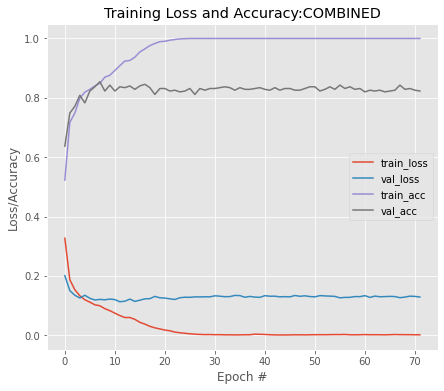

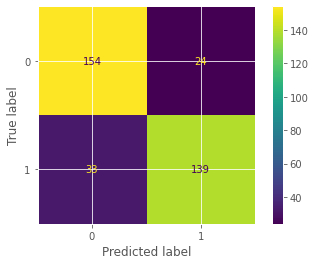

Dataset  Accuracy  Precision   Recall        F1       AUC  Sensitivity  \
0  COMBINED  0.837143   0.852761  0.80814  0.829851  0.836654      0.80814   

   Specificity     Kappa  
0     0.865169  0.673902

Passed:['COMBINED', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8371428571428572, 0.852760736196319, 0.8081395348837209, 0.8298507462686566, 0.8366540371047819, 0.8081395348837209, 0.8651685393258427, 0.6739023832096505]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/43 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.5242
Epoch 1: val_loss improved from inf to 0.20016, saving model to ./result/weights.h5
43/43 [==============================] - 16s 374ms/step - loss: 0.3268 - accuracy: 0.5242 - val_loss: 0.2002 - val_accuracy: 0.6371
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.7067
Epoch 2: val_loss improved from 0.20016 to 0.15189, saving model to ./result/weights.h5
43/43 [==============================] - 16s 369ms/step - loss: 0.1984 - accuracy: 0.7067 - val_loss: 0.1519 - val_accuracy: 0.7343
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.7588
Epoch 3: val_loss improved from 0.15189 to 0.13420, saving model to ./result/weights.h5
43/43 [==============================] - 16s 368ms/step - loss: 0.1507 - accuracy: 0.7588 - val_loss: 0.1342 - val_accuracy: 0.7657
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.

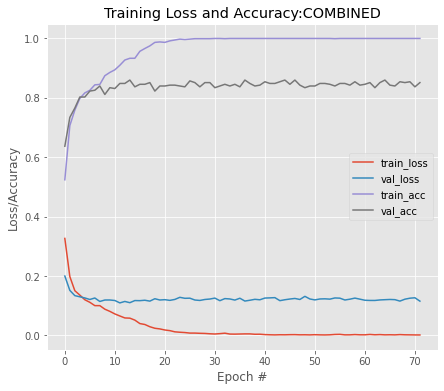

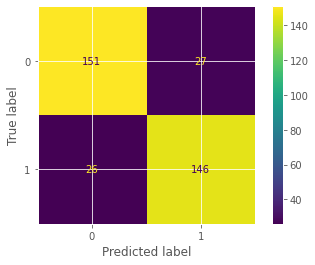

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  COMBINED  0.848571   0.843931  0.848837  0.846377  0.848576     0.848837   

   Specificity     Kappa  
0     0.848315  0.697084

Passed:['COMBINED', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8485714285714285, 0.8439306358381503, 0.8488372093023255, 0.8463768115942029, 0.8485759080219493, 0.8488372093023255, 0.848314606741573, 0.6970835102387407]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/43 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.5022
Epoch 1: val_loss improved from inf to 0.21907, saving model to ./result/weights.h5
43/43 [==============================] - 14s 314ms/step - loss: 0.3190 - accuracy: 0.5022 - val_loss: 0.2191 - val_accuracy: 0.4886
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.5667
Epoch 2: val_loss improved from 0.21907 to 0.19849, saving model to ./result/weights.h5
43/43 [==============================] - 14s 318ms/step - loss: 0.2240 - accuracy: 0.5667 - val_loss: 0.1985 - val_accuracy: 0.6143
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.6811
Epoch 3: val_loss improved from 0.19849 to 0.17574, saving model to ./result/weights.h5
43/43 [==============================] - 14s 323ms/step - loss: 0.1915 - accuracy: 0.6811 - val_loss: 0.1757 - val_accuracy: 0.7000
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.

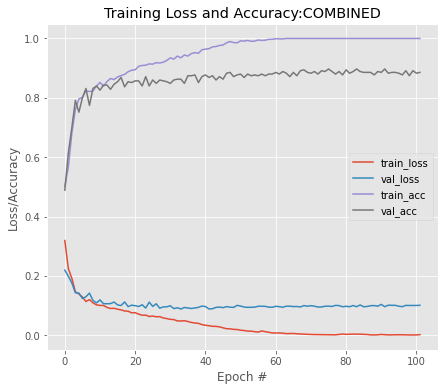

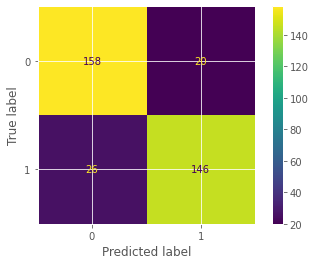

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  COMBINED  0.868571   0.879518  0.848837  0.863905  0.868239     0.848837   

   Specificity     Kappa  
0      0.88764  0.736911

Passed:['COMBINED', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8685714285714285, 0.8795180722891566, 0.8488372093023255, 0.863905325443787, 0.8682388293702638, 0.8488372093023255, 0.8876404494382022, 0.7369109092097523]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


43/43 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.5029
Epoch 1: val_loss improved from inf to 0.22349, saving model to ./result/weights.h5
43/43 [==============================] - 16s 366ms/step - loss: 0.3199 - accuracy: 0.5029 - val_loss: 0.2235 - val_accuracy: 0.4914
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.5960
Epoch 2: val_loss did not improve from 0.22349
43/43 [==============================] - 15s 358ms/step - loss: 0.2154 - accuracy: 0.5960 - val_loss: 0.2372 - val_accuracy: 0.4943
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.6488
Epoch 3: val_loss improved from 0.22349 to 0.16555, saving model to ./result/weights.h5
43/43 [==============================] - 16s 362ms/step - loss: 0.1933 - accuracy: 0.6488 - val_loss: 0.1656 - val_accuracy: 0.6886
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.7603
Epoch 4: val_loss

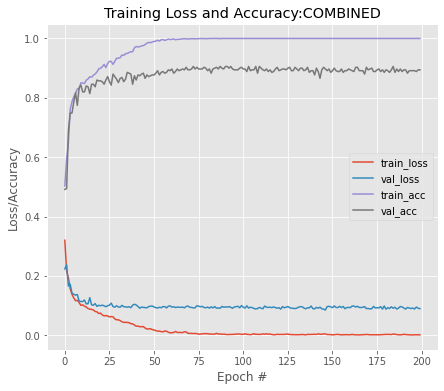

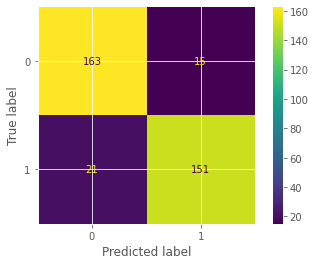

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  COMBINED  0.897143   0.909639  0.877907  0.893491  0.896819     0.877907   

   Specificity     Kappa  
0      0.91573  0.794104

Passed:['COMBINED', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8971428571428571, 0.9096385542168675, 0.877906976744186, 0.8934911242603549, 0.8968186569114189, 0.877906976744186, 0.9157303370786517, 0.7941041898163279]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_

In [ ]:
run_task1(dataset_name='COMBINED',width=64,height=64,validation_split=False)

# ACRIMA

Model:Dataset:ACRIMA, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:False
Width:64,Hist:True
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:564
Received Test:141
New Train:564
New Validate:141
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                               
                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.5564
Epoch 1: val_loss improved from inf to 0.31965, saving model to ./result/weights.h5
17/17 [==============================] - 6s 348ms/step - loss: 0.4224 - accuracy: 0.5564 - val_loss: 0.3197 - val_accuracy: 0.5887
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.5526
Epoch 2: val_loss improved from 0.31965 to 0.25710, saving model to ./result/weights.h5
17/17 [==============================] - 5s 324ms/step - loss: 0.3132 - accuracy: 0.5526 - val_loss: 0.2571 - val_accuracy: 0.5887
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.5478
Epoch 3: val_loss improved from 0.25710 to 0.23596, saving model to ./result/weights.h5
17/17 [==============================] - 6s 328ms/step - loss: 0.2458 - accuracy: 0.5478 - val_loss: 0.2360 - val_accuracy: 0.5887
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.191

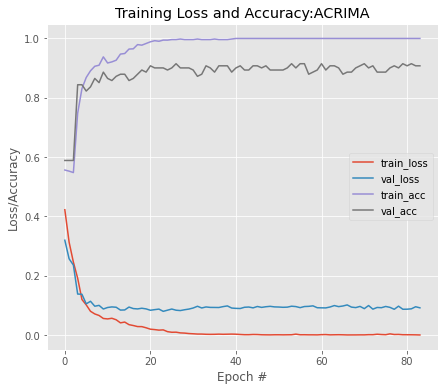

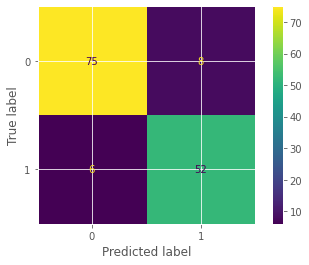

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  ACRIMA  0.900709   0.866667  0.896552  0.881356  0.900083     0.896552   

   Specificity     Kappa  
0     0.903614  0.796032

Passed:['ACRIMA', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.900709219858156, 0.8666666666666667, 0.896551724137931, 0.8813559322033899, 0.9000830909846282, 0.896551724137931, 0.9036144578313253, 0.7960322380657161]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[256

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.5564
Epoch 1: val_loss improved from inf to 0.31636, saving model to ./result/weights.h5
17/17 [==============================] - 7s 385ms/step - loss: 0.4221 - accuracy: 0.5564 - val_loss: 0.3164 - val_accuracy: 0.5887
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.5526
Epoch 2: val_loss improved from 0.31636 to 0.31287, saving model to ./result/weights.h5
17/17 [==============================] - 6s 380ms/step - loss: 0.2989 - accuracy: 0.5526 - val_loss: 0.3129 - val_accuracy: 0.5887
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.5570
Epoch 3: val_loss improved from 0.31287 to 0.23080, saving model to ./result/weights.h5
17/17 [==============================] - 7s 385ms/step - loss: 0.2733 - accuracy: 0.5570 - val_loss: 0.2308 - val_accuracy: 0.5887
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.190

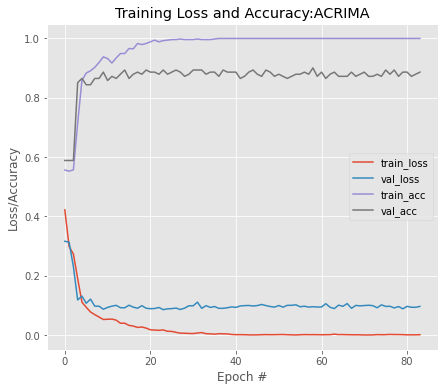

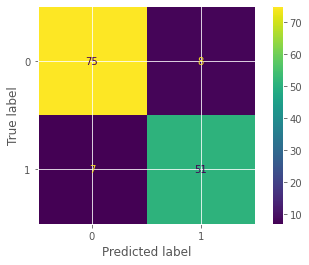

Dataset  Accuracy  Precision   Recall        F1       AUC  Sensitivity  \
0  ACRIMA  0.893617   0.864407  0.87931  0.871795  0.891462      0.87931   

   Specificity     Kappa  
0     0.903614  0.780897

Passed:['ACRIMA', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8936170212765957, 0.864406779661017, 0.8793103448275862, 0.8717948717948718, 0.8914624013294559, 0.8793103448275862, 0.9036144578313253, 0.7808971304257744]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.5451
Epoch 1: val_loss improved from inf to 0.30564, saving model to ./result/weights.h5
17/17 [==============================] - 6s 323ms/step - loss: 0.4303 - accuracy: 0.5451 - val_loss: 0.3056 - val_accuracy: 0.5887
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.5188
Epoch 2: val_loss did not improve from 0.30564
17/17 [==============================] - 5s 311ms/step - loss: 0.3832 - accuracy: 0.5188 - val_loss: 0.4005 - val_accuracy: 0.4113
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.4430
Epoch 3: val_loss did not improve from 0.30564
17/17 [==============================] - 5s 319ms/step - loss: 0.3890 - accuracy: 0.4430 - val_loss: 0.3589 - val_accuracy: 0.4113
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.4436
Epoch 4: val_loss improved from 0.30564 to 0.25763, saving mo

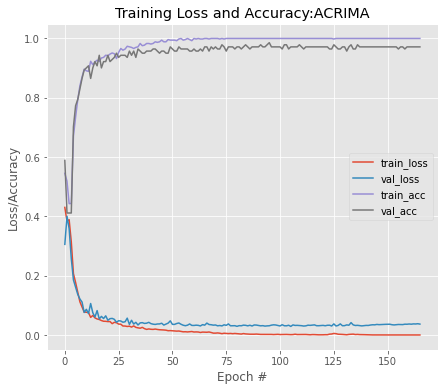

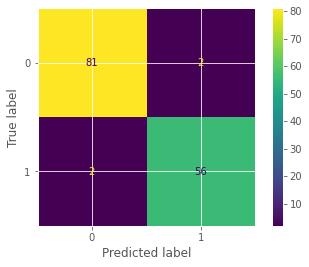

Dataset  Accuracy  Precision    Recall        F1      AUC  Sensitivity  \
0  ACRIMA  0.971631   0.965517  0.965517  0.965517  0.97071     0.965517   

   Specificity     Kappa  
0     0.975904  0.941421

Passed:['ACRIMA', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9716312056737588, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.970710427918571, 0.9655172413793104, 0.9759036144578314, 0.9414208558371416]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_[

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.5451
Epoch 1: val_loss improved from inf to 0.30597, saving model to ./result/weights.h5
17/17 [==============================] - 6s 378ms/step - loss: 0.4301 - accuracy: 0.5451 - val_loss: 0.3060 - val_accuracy: 0.5887
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.5526
Epoch 2: val_loss did not improve from 0.30597
17/17 [==============================] - 6s 365ms/step - loss: 0.3319 - accuracy: 0.5526 - val_loss: 0.3606 - val_accuracy: 0.5887
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.5570
Epoch 3: val_loss improved from 0.30597 to 0.23609, saving model to ./result/weights.h5
17/17 [==============================] - 6s 377ms/step - loss: 0.2785 - accuracy: 0.5570 - val_loss: 0.2361 - val_accuracy: 0.5887
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.6917
Epoch 4: val_loss im

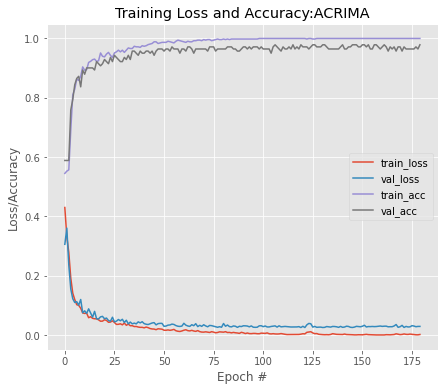

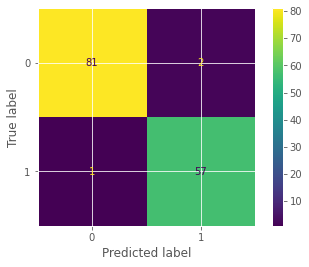

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  ACRIMA  0.978723   0.966102  0.982759  0.974359  0.979331     0.982759   

   Specificity     Kappa  
0     0.975904  0.956179

Passed:['ACRIMA', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.9787234042553191, 0.9661016949152542, 0.9827586206896551, 0.9743589743589743, 0.9793311175737432, 0.9827586206896551, 0.9759036144578314, 0.9561794260851548]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_

In [ ]:
run_task1(dataset_name='ACRIMA',width=64,height=64,validation_split=False)

# RIM-ONE DL

Model:Dataset:RIMONE_DL, Image size:64*64,filter:[256],kernel:[9],stride:[1, 2],validation_split:False
Width:64,Hist:False
Width:64,Hist:False
Received validate_test:32,16,[9],[256],[1, 2],False
Received Train:339
Received Test:146
New Train:339
New Validate:146
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(32, 64, 64, 3)]         0         
                                                                 
 conv0 (Conv2D)              (32, 56, 56, 256)         62464     
                                                                 
 primary_capsule_conv (Conv2  (32, 24, 24, 512)        10617344  
 D)                                                              
                                                                 
 primarycap_reshape (Reshape  (32, 18432, 16)          0         
 )                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 0.34901, saving model to ./result/weights.h5
10/10 [==============================] - 6s 622ms/step - loss: 0.4450 - accuracy: 0.6352 - val_loss: 0.3490 - val_accuracy: 0.6438
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.6482
Epoch 2: val_loss did not improve from 0.34901
10/10 [==============================] - 3s 317ms/step - loss: 0.3854 - accuracy: 0.6482 - val_loss: 0.3942 - val_accuracy: 0.6438
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.6515
Epoch 3: val_loss did not improve from 0.34901
10/10 [==============================] - 3s 318ms/step - loss: 0.3901 - accuracy: 0.6515 - val_loss: 0.3740 - val_accuracy: 0.6438
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.5342
Epoch 4: val_loss improved from 0.34901 to 0.27083, saving mo

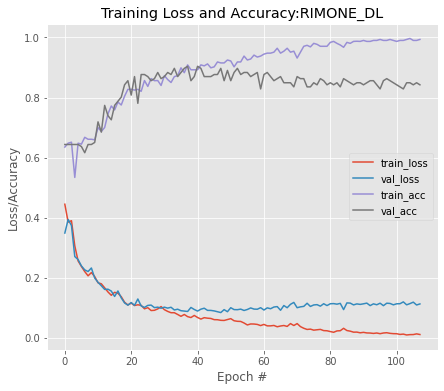

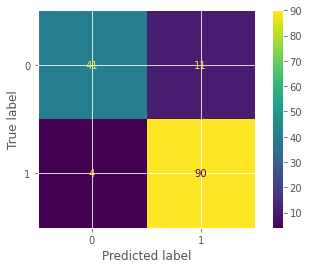

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_DL   0.89726   0.891089  0.957447  0.923077  0.872954     0.957447   

   Specificity     Kappa  
0     0.788462  0.769036

Passed:['RIMONE_DL', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8972602739726028, 0.8910891089108911, 0.9574468085106383, 0.9230769230769231, 0.8729541734860884, 0.9574468085106383, 0.7884615384615384, 0.7690360683400127]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 0.34930, saving model to ./result/weights.h5
10/10 [==============================] - 4s 402ms/step - loss: 0.4449 - accuracy: 0.6352 - val_loss: 0.3493 - val_accuracy: 0.6438
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.6482
Epoch 2: val_loss did not improve from 0.34930
10/10 [==============================] - 4s 379ms/step - loss: 0.3856 - accuracy: 0.6482 - val_loss: 0.3944 - val_accuracy: 0.6438
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.6515
Epoch 3: val_loss did not improve from 0.34930
10/10 [==============================] - 4s 378ms/step - loss: 0.3903 - accuracy: 0.6515 - val_loss: 0.3742 - val_accuracy: 0.6438
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.5603
Epoch 4: val_loss improved from 0.34930 to 0.26647, saving mo

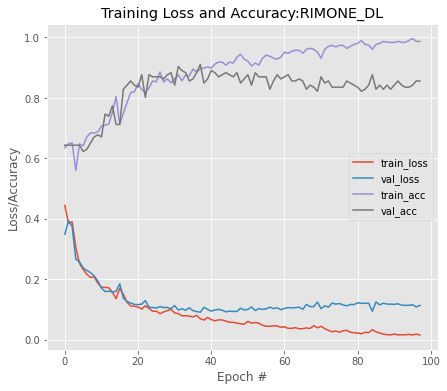

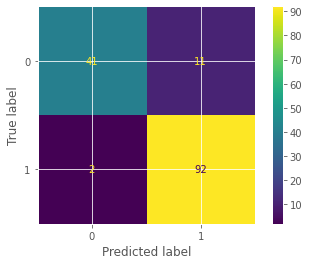

Dataset  Accuracy  Precision    Recall       F1       AUC  Sensitivity  \
0  RIMONE_DL  0.910959   0.893204  0.978723  0.93401  0.883592     0.978723   

   Specificity     Kappa  
0     0.788462  0.798042

Passed:['RIMONE_DL', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_False', 0.910958904109589, 0.8932038834951457, 0.9787234042553191, 0.934010152284264, 0.8835924713584288, 0.9787234042553191, 0.7884615384615384, 0.7980421366248138]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_F_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 0.34901, saving model to ./result/weights.h5
10/10 [==============================] - 3s 345ms/step - loss: 0.4450 - accuracy: 0.6352 - val_loss: 0.3490 - val_accuracy: 0.6438
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.6482
Epoch 2: val_loss did not improve from 0.34901
10/10 [==============================] - 3s 325ms/step - loss: 0.3854 - accuracy: 0.6482 - val_loss: 0.3942 - val_accuracy: 0.6438
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.6515
Epoch 3: val_loss did not improve from 0.34901
10/10 [==============================] - 3s 323ms/step - loss: 0.3901 - accuracy: 0.6515 - val_loss: 0.3741 - val_accuracy: 0.6438
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.5342
Epoch 4: val_loss improved from 0.34901 to 0.27100, saving mo

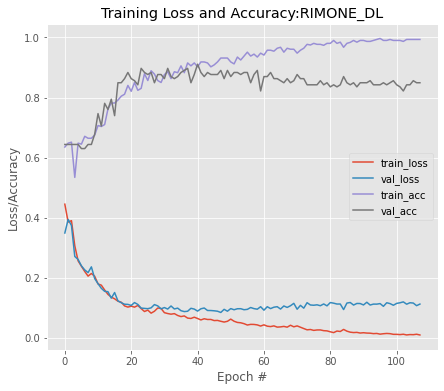

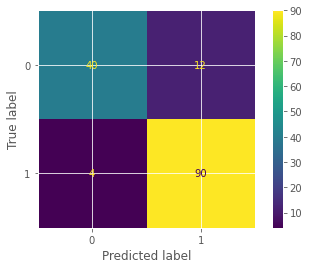

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_DL  0.890411   0.882353  0.957447  0.918367  0.863339     0.957447   

   Specificity     Kappa  
0     0.769231  0.752542

Passed:['RIMONE_DL', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8904109589041096, 0.8823529411764706, 0.9574468085106383, 0.9183673469387754, 0.8633387888707038, 0.9574468085106383, 0.7692307692307693, 0.752542372881356]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False_

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.6352
Epoch 1: val_loss improved from inf to 0.34930, saving model to ./result/weights.h5
10/10 [==============================] - 4s 421ms/step - loss: 0.4449 - accuracy: 0.6352 - val_loss: 0.3493 - val_accuracy: 0.6438
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.6482
Epoch 2: val_loss did not improve from 0.34930
10/10 [==============================] - 4s 381ms/step - loss: 0.3856 - accuracy: 0.6482 - val_loss: 0.3944 - val_accuracy: 0.6438
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.6515
Epoch 3: val_loss did not improve from 0.34930
10/10 [==============================] - 4s 379ms/step - loss: 0.3903 - accuracy: 0.6515 - val_loss: 0.3742 - val_accuracy: 0.6438
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.5635
Epoch 4: val_loss improved from 0.34930 to 0.26647, saving mo

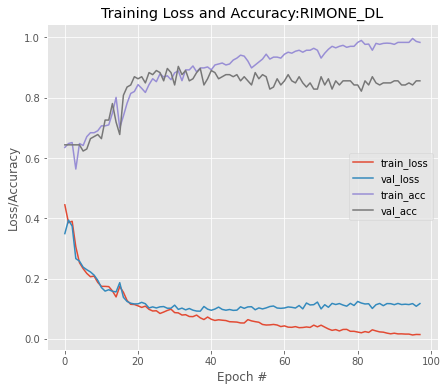

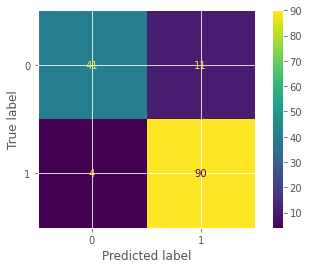

Dataset  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  RIMONE_DL   0.89726   0.891089  0.957447  0.923077  0.872954     0.957447   

   Specificity     Kappa  
0     0.788462  0.769036

Passed:['RIMONE_DL', 'IMG_64_R_8_H_False_F_[256]_K_[9]_S_[1, 2]_V_False', 0.8972602739726028, 0.8910891089108911, 0.9574468085106383, 0.9230769230769231, 0.8729541734860884, 0.9574468085106383, 0.7884615384615384, 0.7690360683400127]
Existing:[['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.9017857142857144, 0.9777777777777776, 0.8148148148148148, 0.8888888888888888, 0.898786717752235, 0.8148148148148148, 0.9827586206896552, 0.8021836865767502], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_True_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.9772727272727272, 0.7962962962962963, 0.8775510204081632, 0.8895274584929757, 0.7962962962962963, 0.9827586206896552, 0.7840616966580977], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_1_H_False_F_[256]_K_[9]_S_[1, 2]_V_True', 0.8928571428571429, 0.903846153846154, 0.8703703703703703, 0.8867924528301887, 0.892081736909323, 0.8703703703703703, 0.913793103448276, 0.7851662404092071], ['RIM-ONE_V2_DRISTI_GS1', 'IMG_64_R_8_H_False

In [ ]:
run_task1(dataset_name='RIMONE_DL',width=64,height=64,validation_split=False)